=== XGBoost version 1 - Only original wastewater features ===

1. Load data...
Data shape: (2398, 20)
Date range: 2020-09-04 00:00:00 to 2021-02-10 00:00:00
Number of CIS regions: 27

Original features (15 features):
   1. sars_cov2_gc_l_mean
   2. suspended_solids_mg_l
   3. ammonia_mg_l
   4. ophosph_mg_l
   5. sample_ph_pre_ansis
   6. control_gc_l_mean
   7. raw_ansis_sars_repc_std
   8. grab_compo_boo
   9. sars_below_lod
  10. sars_below_loq
  11. reception_delay
  12. catchment_population_ons_mid_2019
  13. catchment_area
  14. catch_in_cis_prop
  15. catch_cis_population

2. Build flexible time window data set...
Time range analysis:
  Earliest date in data: 2020-09-04
  Latest date in data: 2021-02-10
  Earliest predict date: 2020-09-11 (Day 8)

=== Data availability statistics ===
Prediction day statistics:
  Total days in data: 2398
  Days satisfying the time window requirement: 4131
  Actual days with data: 2290
  Prediction day utilization: 55.4%

History window statistics

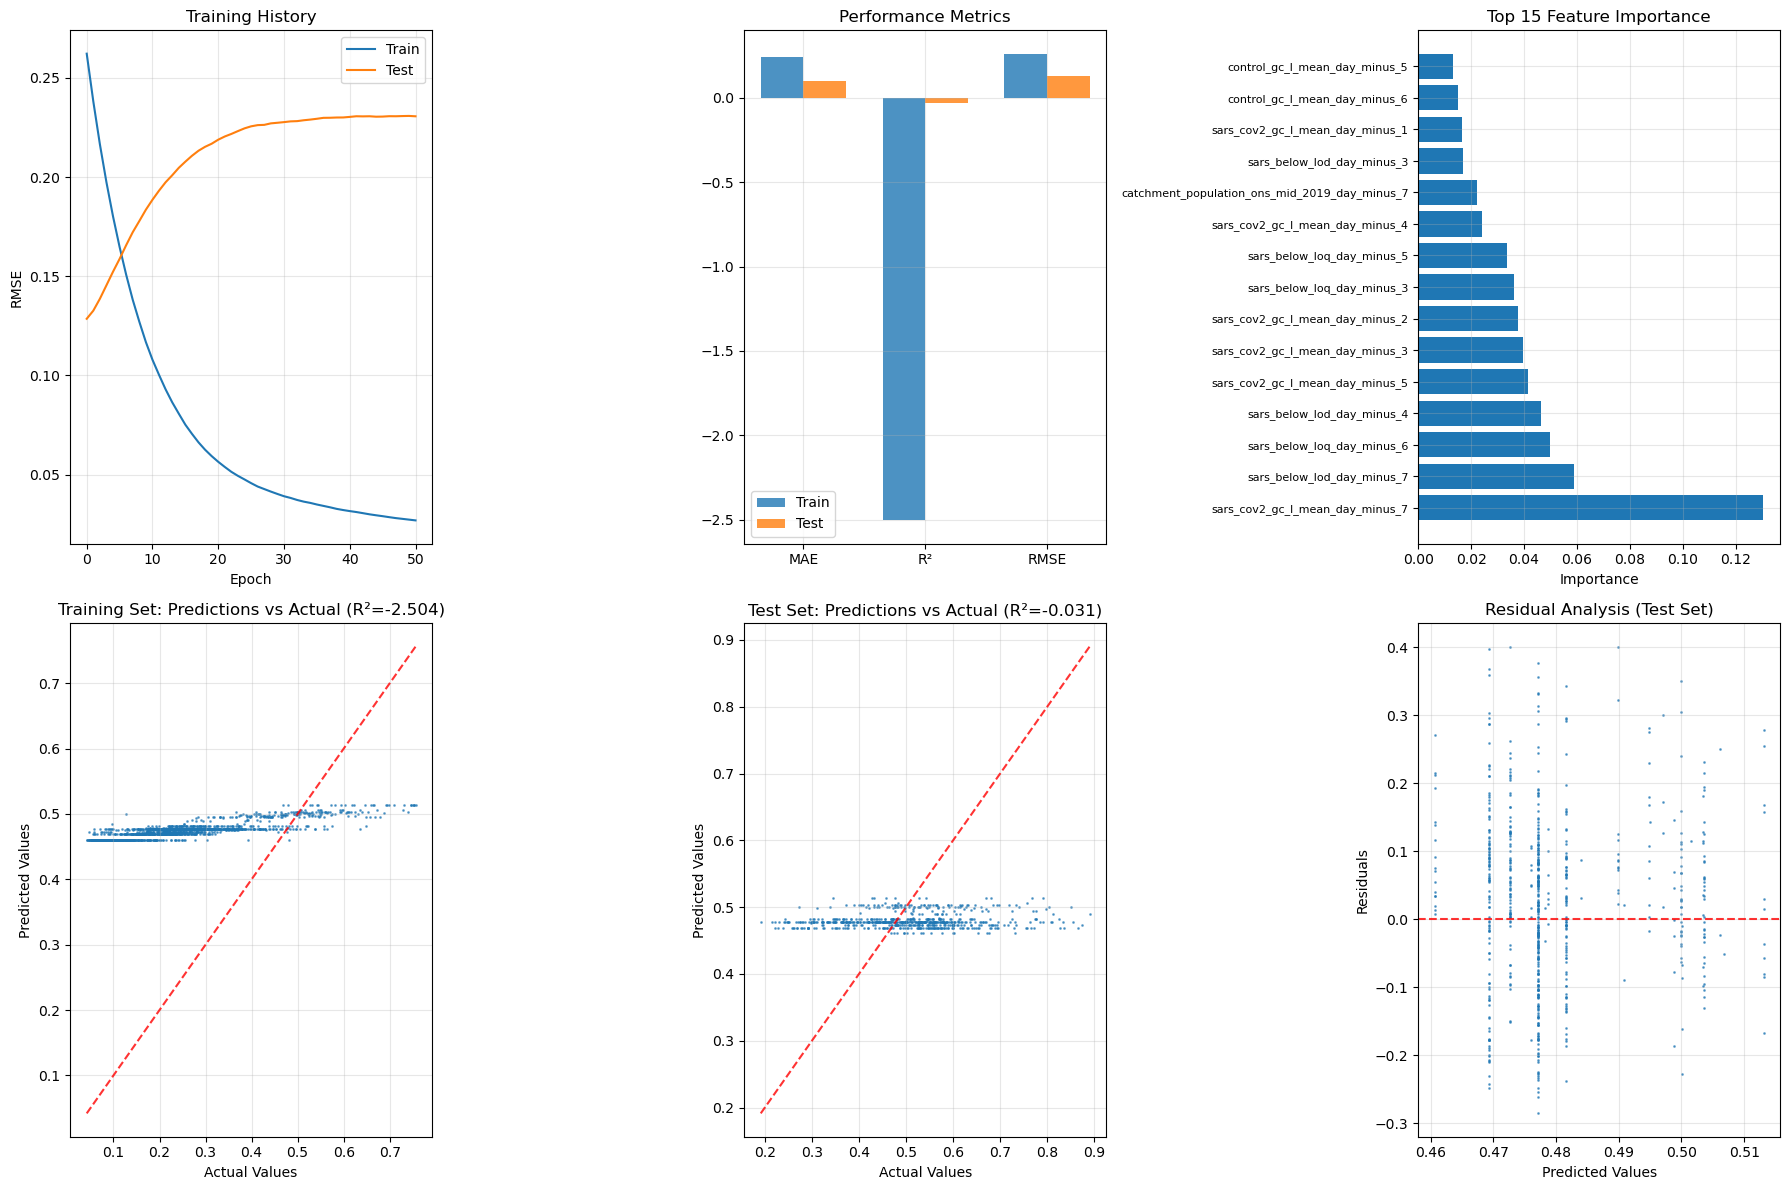


9. Save model and results...
Model and results saved

XGBoost model training completed (flexible time window + only original wastewater features)
Feature composition:
  - Time series features: 15 features/day × 7 days = 105 features
  - Availability flags: 7 flags
  - Total number of features: 112 features

Core strategy:
  ✓ Prediction day starts from the 8th day of the data, ensure a complete history window
  ✓ Strict 7-day time window, do not use data from the prediction day
  ✓ Flexible handling of missing data, use 0 to fill to maintain time logic
  ✓ Only use original wastewater features, maintain feature purity
  ✓ Include data availability flags, help the model identify valid data

Final performance:
  ✓ Test set MAE: 0.1015
  ✓ Test set R²: -0.0313
  ✓ Test set RMSE: 0.1286


In [1]:
##### XGBoost version 1 - Only original wastewater features

print("=== XGBoost version 1 - Only original wastewater features ===")

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')

# Create necessary directories
os.makedirs('../models', exist_ok=True)
os.makedirs('../results', exist_ok=True)

# 1. Load data
print("\n1. Load data...")
data = pd.read_csv('../data/processed/london_data_transformed.csv')

# Data preprocessing
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(['CIS20CD', 'date']).reset_index(drop=True)

print(f"Data shape: {data.shape}")
print(f"Date range: {data['date'].min()} to {data['date'].max()}")

# Get CIS regions
cis_regions = data['CIS20CD'].unique()
print(f"Number of CIS regions: {len(cis_regions)}")

# Original features (15 features)
original_features = [
    'sars_cov2_gc_l_mean', 'suspended_solids_mg_l', 'ammonia_mg_l', 'ophosph_mg_l',
    'sample_ph_pre_ansis', 'control_gc_l_mean', 'raw_ansis_sars_repc_std',
    'grab_compo_boo', 'sars_below_lod', 'sars_below_loq', 'reception_delay',
    'catchment_population_ons_mid_2019', 'catchment_area', 'catch_in_cis_prop',
    'catch_cis_population'
]

print(f"\nOriginal features ({len(original_features)} features):")
for i, feat in enumerate(original_features, 1):
    print(f"  {i:2d}. {feat}")

# 2. Prepare flexible time window data (only original features)
print("\n2. Build flexible time window data set...")

def create_flexible_time_window_xgboost_original(data, window_days=7):
    """
    Create flexible time window data set, containing:
    - Original features (15 features) within the last window_days days
    - Target: infection rate of the prediction day
    
    Core strategy:
    1. Prediction day must start from the 8th day of the first date in the data
    2. Each prediction day needs a complete 7-day history window
    3. Use data if available, otherwise use 0
    4. Never use data from the prediction day or future!
    """
    
    X_list = []
    y_list = []
    date_list = []
    cis_list = []
    availability_stats = {
        'total_potential_pred_days': 0,  # Total days in the data
        'valid_pred_days': 0,            # Predict days satisfying the time window requirement
        'actual_pred_days': 0,           # Actual days used for prediction (with data)
        'total_samples': 0,              # Total number of samples
        'total_hist_days': 0,            # Total days in the history window
        'available_hist_days': 0         # Days with data in the history window
    }
    
    # Get the time range of the global data
    global_min_date = data['date'].min()
    global_max_date = data['date'].max()
    earliest_pred_date = global_min_date + pd.Timedelta(days=window_days)
    
    print(f"Time range analysis:")
    print(f"  Earliest date in data: {global_min_date.strftime('%Y-%m-%d')}")
    print(f"  Latest date in data: {global_max_date.strftime('%Y-%m-%d')}")
    print(f"  Earliest predict date: {earliest_pred_date.strftime('%Y-%m-%d')} (Day {window_days+1})")
    
    # Get all CIS regions
    all_cis = sorted(data['CIS20CD'].unique())
    
    # Group by CIS region
    for cis in all_cis:
        cis_data = data[data['CIS20CD'] == cis].copy()
        cis_data = cis_data.sort_values('date').reset_index(drop=True)
        
        if len(cis_data) == 0:
            continue
            
        availability_stats['total_potential_pred_days'] += len(cis_data)
        
        # Create a mapping from date to data for quick lookup
        cis_date_data = {}
        for _, row in cis_data.iterrows():
            cis_date_data[row['date'].date()] = row
        
        # Get the time range of the CIS region
        cis_min_date = cis_data['date'].min()
        cis_max_date = cis_data['date'].max()
        cis_earliest_pred_date = cis_min_date + pd.Timedelta(days=window_days)
        
        # Iterate through all possible prediction dates for this CIS region
        # Start from the 8th day of the CIS region, until the last day
        current_date = cis_earliest_pred_date
        while current_date <= cis_max_date:
            availability_stats['valid_pred_days'] += 1
            
            # Check if the current date has data (can be used as a prediction day)
            if current_date.date() in cis_date_data:
                pred_target = cis_date_data[current_date.date()]['median_prob']
                availability_stats['actual_pred_days'] += 1
                
                # Build a strict 7-day history window (before the prediction day)
                feature_vector = []
                availability_flags = []
                
                for days_back in range(1, window_days + 1):  # 1-7 days before the prediction day
                    hist_date = (current_date - pd.Timedelta(days=days_back)).date()
                    
                    if hist_date in cis_date_data:
                        # Use real data
                        hist_row = cis_date_data[hist_date]
                        # Only use original features (15 features)
                        for feature in original_features:
                            feature_vector.append(hist_row[feature])
                        availability_flags.append(1)  # Mark as having data
                        availability_stats['available_hist_days'] += 1
                    else:
                        # No data: use 0
                        for feature in original_features:
                            feature_vector.append(0.0)
                        availability_flags.append(0)  # Mark as having no data
                    
                    availability_stats['total_hist_days'] += 1
                
                # Add data availability flags as additional features
                feature_vector.extend(availability_flags)
                
                X_list.append(feature_vector)
                y_list.append(pred_target)
                date_list.append(current_date)
                cis_list.append(cis)
                availability_stats['total_samples'] += 1
            
            # Move to the next day
            current_date += pd.Timedelta(days=1)
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    # Create feature names
    feature_names = []
    
    # Time series feature names
    for day in range(1, window_days + 1):
        for feature in original_features:
            feature_names.append(f"{feature}_day_minus_{day}")
    
    # Data availability flags
    for day in range(1, window_days + 1):
        feature_names.append(f"data_available_day_minus_{day}")
    
    # Print detailed data availability statistics
    print(f"\n=== Data availability statistics ===")
    print(f"Prediction day statistics:")
    print(f"  Total days in data: {availability_stats['total_potential_pred_days']}")
    print(f"  Days satisfying the time window requirement: {availability_stats['valid_pred_days']}")
    print(f"  Actual days with data: {availability_stats['actual_pred_days']}")
    print(f"  Prediction day utilization: {availability_stats['actual_pred_days']/availability_stats['valid_pred_days']*100:.1f}%")
    
    print(f"\nHistory window statistics:")
    print(f"  Total history days: {availability_stats['total_hist_days']}")
    print(f"  Days with data in history: {availability_stats['available_hist_days']}")
    print(f"  History data coverage: {availability_stats['available_hist_days']/availability_stats['total_hist_days']*100:.1f}%")
    print(f"  Average number of effective history days per sample: {availability_stats['available_hist_days']/availability_stats['total_samples']:.1f}/7 days")
    
    print(f"\nSample statistics:")
    print(f"  Total samples: {availability_stats['total_samples']}")
    print(f"  Average number of samples per CIS region: {availability_stats['total_samples']/len(all_cis):.1f}")
    
    print(f"\nFeature statistics:")
    print(f"  Feature dimension: {X.shape[1]}")
    print(f"  Time series features: {len(original_features)} × {window_days} = {len(original_features) * window_days}")
    print(f"  Availability flags: {window_days}")
    print(f"  Total number of features: {len(original_features) * window_days + window_days}")
    
    return X, y, np.array(date_list), np.array(cis_list), feature_names

# Create dataset
X, y, sample_dates, sample_cis, feature_names = create_flexible_time_window_xgboost_original(
    data, window_days=7
)

print(f"\n=== Data set shape ===")
print(f"  Feature matrix: {X.shape}")
print(f"  Target vector: {y.shape}")
print(f"  Total number of samples: {len(y)}")

# 特征说明
print(f"\n=== Feature composition ===")
print(f"Time series features (for each sample):")
print(f"  - 1 day before: 15 original features")
print(f"  - 2 days before: 15 original features")
print(f"  - 3 days before: 15 original features")
print(f"  - 4 days before: 15 original features")
print(f"  - 5 days before: 15 original features")
print(f"  - 6 days before: 15 original features")
print(f"  - 7 days before: 15 original features")
print(f"  Total: 15 × 7 = 105 time series features")

print(f"\nData availability flags:")
print(f"  - 7 flags (1=data, 0=no data)")

print(f"\nTotal number of features: 105 + 7 = 112")

print(f"\n=== Strategy verification ===")
print(f"✓ Prediction day selection: start from the 8th day of the data, ensure a complete history window")
print(f"✓ History window: strict 7-day time window (1-7 days before the prediction day)")
print(f"✓ Missing data handling: use 0 for missing data in the history window")
print(f"✓ Time boundary: never use data from the prediction day or future!")
print(f"✓ Feature purity: only use original wastewater features")

# Example of time logic verification
print(f"\n=== Example of time logic verification ===")
if len(sample_dates) > 0:
    # Display the time logic of the first 3 samples
    for i in range(min(3, len(sample_dates))):
        sample_pred_date = sample_dates[i]
        print(f"Sample {i}:")
        print(f"  Prediction day: {sample_pred_date.strftime('%Y-%m-%d')}")
        print(f"  History window: {(sample_pred_date - pd.Timedelta(days=7)).strftime('%Y-%m-%d')} to {(sample_pred_date - pd.Timedelta(days=1)).strftime('%Y-%m-%d')}")
        print(f"  Prediction target: {y[i]:.4f}")
        print(f"  CIS region: {sample_cis[i]}")
        print(f"  Data availability: {X[i, -7:].astype(int)}")  # Last 7 features are availability flags
        print()

# Verify that no future data is used
print(f"=== Time safety verification ===")
min_pred_date = sample_dates.min()
max_pred_date = sample_dates.max()
print(f"Prediction date range: {min_pred_date.strftime('%Y-%m-%d')} to {max_pred_date.strftime('%Y-%m-%d')}")
print(f"Earliest prediction day: {(min_pred_date - data['date'].min()).days} days")
print(f"✓ Confirm: earliest prediction day is at least the 8th day of the data")

# 3. Time split
print("\n3. Time split...")
sample_dates_dt = pd.to_datetime(sample_dates)
sorted_dates = sorted(sample_dates_dt.unique())
split_idx = int(len(sorted_dates) * 0.7)
split_date = sorted_dates[split_idx]

train_mask = sample_dates_dt <= split_date
test_mask = sample_dates_dt > split_date

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"Training set: {len(y_train)} samples")
print(f"Test set: {len(y_test)} samples")
print(f"Split date: {split_date}")

# 4. Feature standardization
print("\n4. Feature standardization...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature standardization completed")

# 5. XGBoost model training
print("\n5. XGBoost model training...")

# Model parameters
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 1,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42,
    'n_jobs': -1
}

print("Model parameters:")
for key, value in params.items():
    print(f"  {key}: {value}")

# Train model
model = xgb.XGBRegressor(**params)

# Use early stopping mechanism
model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
    eval_metric='rmse',
    early_stopping_rounds=50,
    verbose=False
)

print(f"Training completed, best iteration: {model.best_iteration}")

# 6. Model prediction and evaluation
print("\n6. Model prediction and evaluation...")

# Prediction
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Calculate metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("=== Model performance ===")
print(f"Training set:")
print(f"  MAE: {train_mae:.4f}")
print(f"  R²: {train_r2:.4f}")
print(f"  RMSE: {train_rmse:.4f}")

print(f"\nTest set:")
print(f"  MAE: {test_mae:.4f}")
print(f"  R²: {test_r2:.4f}")
print(f"  RMSE: {test_rmse:.4f}")

# 7. Feature importance analysis
print("\n7. Feature importance analysis...")

# Get feature importance
feature_importance = model.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nTop 20 most important features:")
print(importance_df.head(20).to_string(index=False))

# Analyze the importance of different types of features
time_features_importance = importance_df[~importance_df['feature'].str.contains('data_available')]['importance'].sum()
availability_features_importance = importance_df[importance_df['feature'].str.contains('data_available')]['importance'].sum()

print(f"\nFeature type importance:")
print(f"  Time series features total importance: {time_features_importance:.4f}")
print(f"  Availability flags total importance: {availability_features_importance:.4f}")

# 8. Result visualization
print("\n8. Result visualization...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Training history
evals_result = model.evals_result()
epochs = len(evals_result['validation_0']['rmse'])
x_axis = range(0, epochs)

axes[0, 0].plot(x_axis, evals_result['validation_0']['rmse'], label='Train')
axes[0, 0].plot(x_axis, evals_result['validation_1']['rmse'], label='Test')
axes[0, 0].set_title('Training History')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Performance metrics comparison
metrics = ['MAE', 'R²', 'RMSE']
train_vals = [train_mae, train_r2, train_rmse]
test_vals = [test_mae, test_r2, test_rmse]

x = np.arange(len(metrics))
width = 0.35

axes[0, 1].bar(x - width/2, train_vals, width, label='Train', alpha=0.8)
axes[0, 1].bar(x + width/2, test_vals, width, label='Test', alpha=0.8)
axes[0, 1].set_title('Performance Metrics')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(metrics)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Feature importance (top 15)
top_features = importance_df.head(15)
axes[0, 2].barh(range(len(top_features)), top_features['importance'])
axes[0, 2].set_yticks(range(len(top_features)))
axes[0, 2].set_yticklabels(top_features['feature'], fontsize=8)
axes[0, 2].set_title('Top 15 Feature Importance')
axes[0, 2].set_xlabel('Importance')
axes[0, 2].grid(True, alpha=0.3)

# Predictions vs actual values - training set
axes[1, 0].scatter(y_train, y_train_pred, alpha=0.6, s=1)
axes[1, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', alpha=0.8)
axes[1, 0].set_title(f'Training Set: Predictions vs Actual (R²={train_r2:.3f})')
axes[1, 0].set_xlabel('Actual Values')
axes[1, 0].set_ylabel('Predicted Values')
axes[1, 0].grid(True, alpha=0.3)

# Predictions vs actual values - test set
axes[1, 1].scatter(y_test, y_test_pred, alpha=0.6, s=1)
axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', alpha=0.8)
axes[1, 1].set_title(f'Test Set: Predictions vs Actual (R²={test_r2:.3f})')
axes[1, 1].set_xlabel('Actual Values')
axes[1, 1].set_ylabel('Predicted Values')
axes[1, 1].grid(True, alpha=0.3)

# Residual analysis
test_residuals = y_test - y_test_pred
axes[1, 2].scatter(y_test_pred, test_residuals, alpha=0.6, s=1)
axes[1, 2].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[1, 2].set_title('Residual Analysis (Test Set)')
axes[1, 2].set_xlabel('Predicted Values')
axes[1, 2].set_ylabel('Residuals')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/xgboost_version_1_original_features.png', dpi=300, bbox_inches='tight')
plt.show()

# 9. Save model and results
print("\n9. Save model and results...")

# Save model
model.save_model('../models/xgboost_version_1_original_features.json')

# Save feature importance
importance_df.to_csv('../results/xgboost_version_1_feature_importance.csv', index=False)

# Save prediction results
results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_test_pred,
    'residual': y_test - y_test_pred,
    'date': sample_dates[test_mask],
    'cis_code': sample_cis[test_mask]
})
results_df.to_csv('../results/xgboost_version_1_predictions.csv', index=False)

print("Model and results saved")

print("\n" + "="*80)
print("XGBoost model training completed (flexible time window + only original wastewater features)")
print("="*80)
print(f"Feature composition:")
print(f"  - Time series features: 15 features/day × 7 days = 105 features")
print(f"  - Availability flags: 7 flags")
print(f"  - Total number of features: 112 features")
print(f"\nCore strategy:")
print(f"  ✓ Prediction day starts from the 8th day of the data, ensure a complete history window")
print(f"  ✓ Strict 7-day time window, do not use data from the prediction day")
print(f"  ✓ Flexible handling of missing data, use 0 to fill to maintain time logic")
print(f"  ✓ Only use original wastewater features, maintain feature purity")
print(f"  ✓ Include data availability flags, help the model identify valid data")
print(f"\nFinal performance:")
print(f"  ✓ Test set MAE: {test_mae:.4f}")
print(f"  ✓ Test set R²: {test_r2:.4f}")
print(f"  ✓ Test set RMSE: {test_rmse:.4f}")
print("="*80)

=== XGBoost version 2 - Include past 7-day infection rate features ===

1. Loading data...
Data shape: (2398, 20)
Time range: 2020-09-04 00:00:00 to 2021-02-10 00:00:00
Number of CIS regions: 27

Original features (15 features):
   1. sars_cov2_gc_l_mean
   2. suspended_solids_mg_l
   3. ammonia_mg_l
   4. ophosph_mg_l
   5. sample_ph_pre_ansis
   6. control_gc_l_mean
   7. raw_ansis_sars_repc_std
   8. grab_compo_boo
   9. sars_below_lod
  10. sars_below_loq
  11. reception_delay
  12. catchment_population_ons_mid_2019
  13. catchment_area
  14. catch_in_cis_prop
  15. catch_cis_population

2. Build flexible time window data set...
Time range analysis:
  Earliest date: 2020-09-04
  Latest date: 2021-02-10
  Earliest predict date: 2020-09-11 (Day 8)

=== Data availability statistics ===
Prediction day statistics:
  Total days in the data: 2398
  Days satisfying the time window: 4131
  Days with actual data: 2290
  Prediction day utilization: 55.4%

History window statistics:
  Total hi

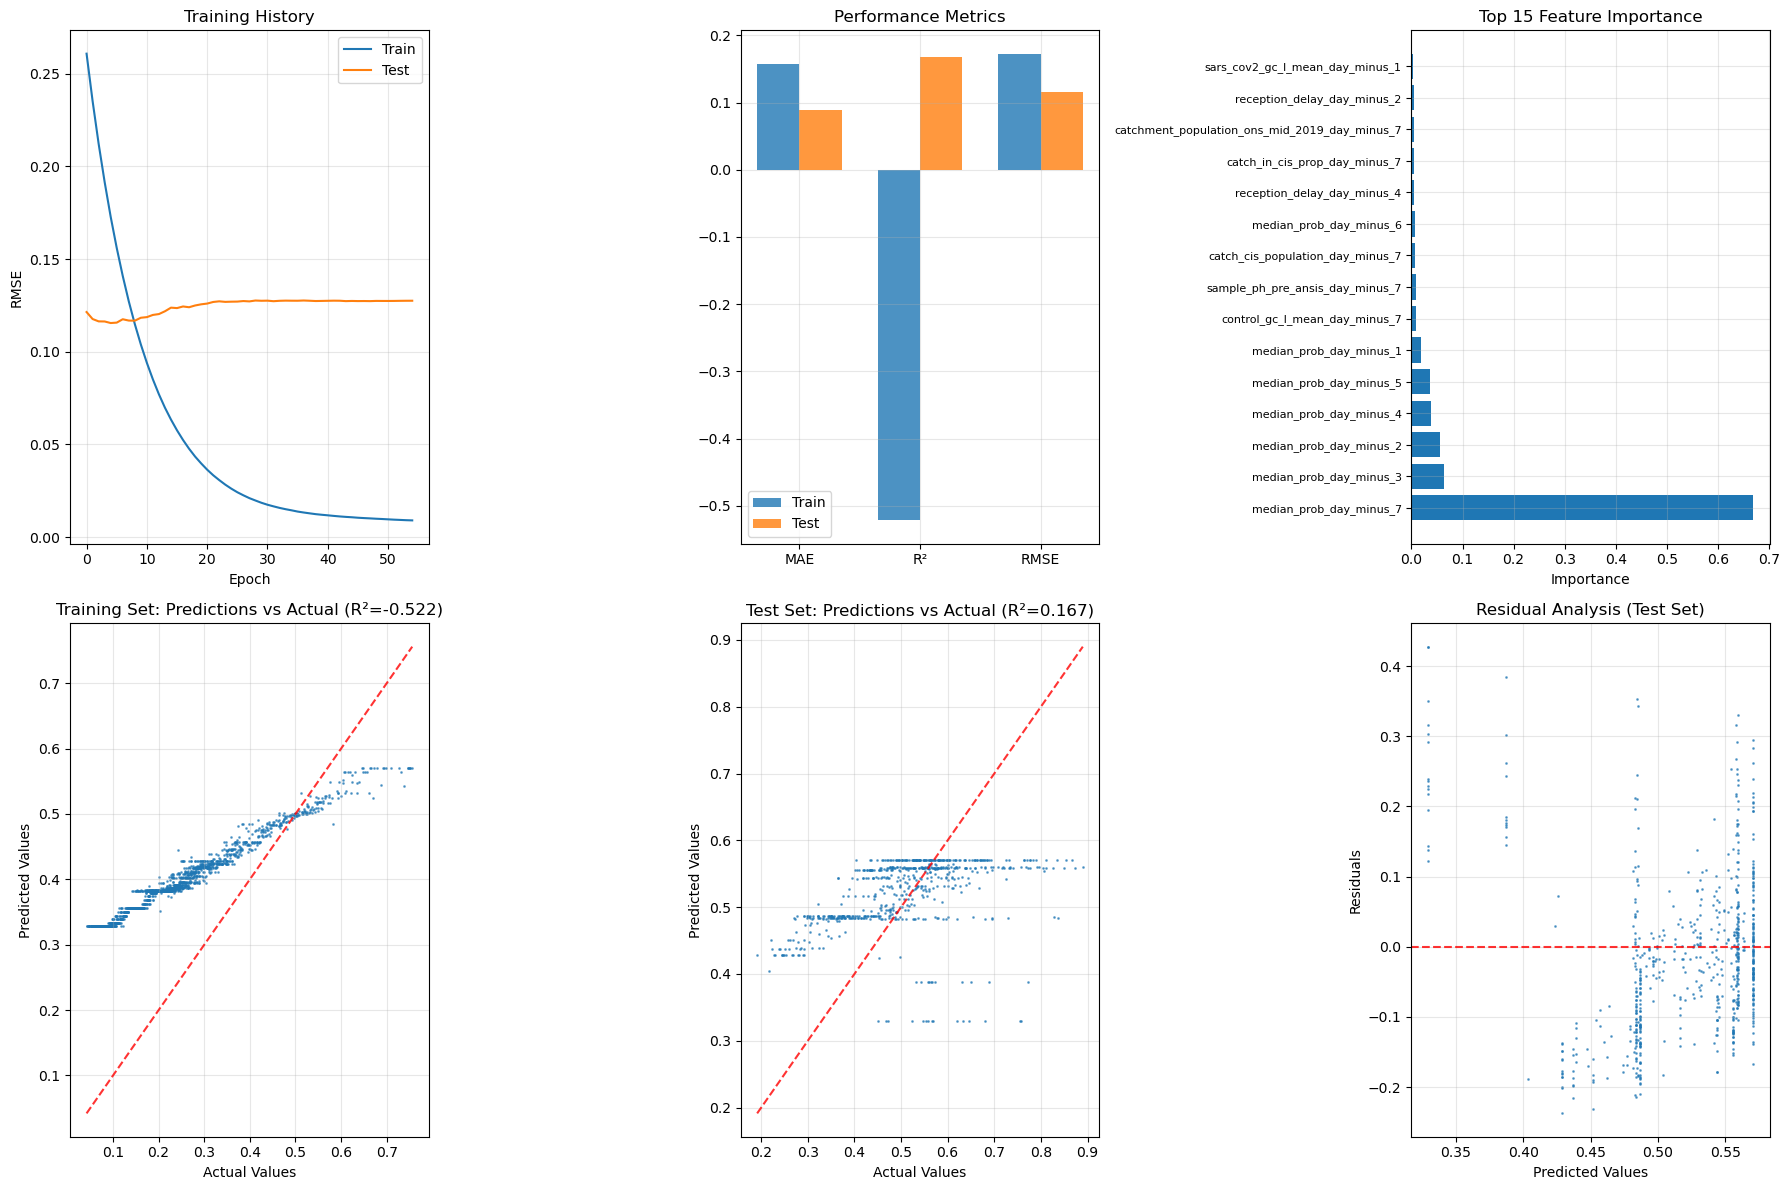


9. Save model and results...
Model and results saved

XGBoost model training completed (flexible time window + include past 7-day infection rate features)
Feature composition:
  - Time series features: 16 features/day × 7 days = 112 features
    * Original wastewater features: 15 features/day
    * History infection rate features: 1 feature/day
  - Availability flags: 7 flags
  - Total features: 119 features

Core strategy:
  ✓ Prediction day starts from the 8th day of the data, ensure a complete history window
  ✓ Strict 7-day time window, do not use data from the prediction day
  ✓ Flexible handling of missing data, use 0 to fill to maintain time logic
  ✓ Include infection rate data for each day in the past 7 days
  ✓ Include original wastewater detection features
  ✓ Include data availability flags to help the model identify valid data

Final performance:
  ✓ Test set MAE: 0.0895
  ✓ Test set R²: 0.1673
  ✓ Test set RMSE: 0.1155

Feature contribution:
  ✓ Original features ratio: 

In [2]:
##### XGBoost version 2 - Include past 7-day infection rate features

print("=== XGBoost version 2 - Include past 7-day infection rate features ===")

# 1. Data loading
print("\n1. Loading data...")
data = pd.read_csv('../data/processed/london_data_transformed.csv')

# Data preprocessing
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(['CIS20CD', 'date']).reset_index(drop=True)

print(f"Data shape: {data.shape}")
print(f"Time range: {data['date'].min()} to {data['date'].max()}")

# Get CIS regions
cis_regions = data['CIS20CD'].unique()
print(f"Number of CIS regions: {len(cis_regions)}")

# Original features (15 features)
original_features = [
    'sars_cov2_gc_l_mean', 'suspended_solids_mg_l', 'ammonia_mg_l', 'ophosph_mg_l',
    'sample_ph_pre_ansis', 'control_gc_l_mean', 'raw_ansis_sars_repc_std',
    'grab_compo_boo', 'sars_below_lod', 'sars_below_loq', 'reception_delay',
    'catchment_population_ons_mid_2019', 'catchment_area', 'catch_in_cis_prop',
    'catch_cis_population'
]

print(f"\nOriginal features ({len(original_features)} features):")
for i, feat in enumerate(original_features, 1):
    print(f"  {i:2d}. {feat}")

# 2. Prepare flexible time window data (include past 7-day infection rate features)
print("\n2. Build flexible time window data set...")

def create_flexible_time_window_xgboost_with_infection_rates(data, window_days=7):
    """
    Create flexible time window data set, including:
    - Original features (15 features) within the past window_days days
    - Infection rate data (1 feature) within the past window_days days
    - Target: infection rate of the prediction day
    
    Core strategy:
    1. Prediction day must start from the 8th day of the data
    2. Each prediction day needs a complete 7-day history window
    3. Use data if available, otherwise use 0
    4. Never use data from the prediction day or future!
    """
    
    X_list = []
    y_list = []
    date_list = []
    cis_list = []
    availability_stats = {
        'total_potential_pred_days': 0,  # Total days in the data
        'valid_pred_days': 0,            # Predict days satisfying the time window
        'actual_pred_days': 0,           # Actual days used for prediction (with data)
        'total_samples': 0,              # Total number of samples
        'total_hist_days': 0,            # Total days in the history window
        'available_hist_days': 0         # Days with data in the history window
    }
    
    # Get the time range of the global data
    global_min_date = data['date'].min()
    global_max_date = data['date'].max()
    earliest_pred_date = global_min_date + pd.Timedelta(days=window_days)
    
    print(f"Time range analysis:")
    print(f"  Earliest date: {global_min_date.strftime('%Y-%m-%d')}")
    print(f"  Latest date: {global_max_date.strftime('%Y-%m-%d')}")
    print(f"  Earliest predict date: {earliest_pred_date.strftime('%Y-%m-%d')} (Day {window_days+1})")
    
    # Get all CIS regions
    all_cis = sorted(data['CIS20CD'].unique())
    
    # Group by CIS region
    for cis in all_cis:
        cis_data = data[data['CIS20CD'] == cis].copy()
        cis_data = cis_data.sort_values('date').reset_index(drop=True)
        
        if len(cis_data) == 0:
            continue
            
        availability_stats['total_potential_pred_days'] += len(cis_data)
        
        # Create a mapping from date to data for quick lookup
        cis_date_data = {}
        for _, row in cis_data.iterrows():
            cis_date_data[row['date'].date()] = row
        
        # Get the time range of the CIS region
        cis_min_date = cis_data['date'].min()
        cis_max_date = cis_data['date'].max()
        cis_earliest_pred_date = cis_min_date + pd.Timedelta(days=window_days)
        
        # Iterate through all possible prediction dates for this CIS region
        # Start from the 8th day of the CIS region, to the last day
        current_date = cis_earliest_pred_date
        while current_date <= cis_max_date:
            availability_stats['valid_pred_days'] += 1
            
            # Check if the current date has data (can be used as a prediction day)
            if current_date.date() in cis_date_data:
                pred_target = cis_date_data[current_date.date()]['median_prob']
                availability_stats['actual_pred_days'] += 1
                
                # Build a strict 7-day history window (before the prediction day)
                feature_vector = []
                availability_flags = []
                
                for days_back in range(1, window_days + 1):  # 1-7 days before
                    hist_date = (current_date - pd.Timedelta(days=days_back)).date()
                    
                    if hist_date in cis_date_data:
                        # Data available: use real value
                        hist_row = cis_date_data[hist_date]
                        # Original features (15 features) + infection rate (1 feature) = 16 features
                        for feature in original_features:
                            feature_vector.append(hist_row[feature])
                        # Add history infection rate
                        feature_vector.append(hist_row['median_prob'])
                        availability_flags.append(1)  # Mark as data available
                        availability_stats['available_hist_days'] += 1
                    else:
                        # No data: use 0
                        for feature in original_features:
                            feature_vector.append(0.0)
                        # Infection rate also use 0
                        feature_vector.append(0.0)
                        availability_flags.append(0)  # Mark as no data
                    
                    availability_stats['total_hist_days'] += 1
                
                # Add data availability flags as an additional feature
                feature_vector.extend(availability_flags)
                
                X_list.append(feature_vector)
                y_list.append(pred_target)
                date_list.append(current_date)
                cis_list.append(cis)
                availability_stats['total_samples'] += 1
            
            # Move to the next day
            current_date += pd.Timedelta(days=1)
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    # Create feature names
    feature_names = []
    
    # Time series feature names (original features + infection rate)
    for day in range(1, window_days + 1):
        for feature in original_features:
            feature_names.append(f"{feature}_day_minus_{day}")
        feature_names.append(f"median_prob_day_minus_{day}")
    
    # Data availability flags
    for day in range(1, window_days + 1):
        feature_names.append(f"data_available_day_minus_{day}")
    
    # Print detailed data availability statistics
    print(f"\n=== Data availability statistics ===")
    print(f"Prediction day statistics:")
    print(f"  Total days in the data: {availability_stats['total_potential_pred_days']}")
    print(f"  Days satisfying the time window: {availability_stats['valid_pred_days']}")
    print(f"  Days with actual data: {availability_stats['actual_pred_days']}")
    print(f"  Prediction day utilization: {availability_stats['actual_pred_days']/availability_stats['valid_pred_days']*100:.1f}%")
    
    print(f"\nHistory window statistics:")
    print(f"  Total history days: {availability_stats['total_hist_days']}")
    print(f"  Days with data: {availability_stats['available_hist_days']}")
    print(f"  History data coverage: {availability_stats['available_hist_days']/availability_stats['total_hist_days']*100:.1f}%")
    print(f"  Average effective history days per sample: {availability_stats['available_hist_days']/availability_stats['total_samples']:.1f}/7 days")
    
    print(f"\nSample statistics:")
    print(f"  Total samples: {availability_stats['total_samples']}")
    print(f"  Average samples per CIS region: {availability_stats['total_samples']/len(all_cis):.1f}")
    
    print(f"\nFeature statistics:")
    print(f"  Feature dimension: {X.shape[1]}")
    print(f"  Time series features: {len(original_features) + 1} × {window_days} = {(len(original_features) + 1) * window_days}")
    print(f"  Availability flags: {window_days}")
    print(f"  Total features: {(len(original_features) + 1) * window_days + window_days}")
    
    return X, y, np.array(date_list), np.array(cis_list), feature_names

# Create data set
X, y, sample_dates, sample_cis, feature_names = create_flexible_time_window_xgboost_with_infection_rates(
    data, window_days=7
)

print(f"\n=== Data set shape ===")
print(f"  Feature matrix: {X.shape}")
print(f"  Target vector: {y.shape}")
print(f"  Total samples: {len(y)}")

# Feature description
print(f"\n=== Feature composition ===")
print(f"Time series features (per sample):")
print(f"  - 1 day before: 15 original features + 1 infection rate = 16")
print(f"  - 2 days before: 15 original features + 1 infection rate = 16")
print(f"  - 3 days before: 15 original features + 1 infection rate = 16")
print(f"  - 4 days before: 15 original features + 1 infection rate = 16")
print(f"  - 5 days before: 15 original features + 1 infection rate = 16")
print(f"  - 6 days before: 15 original features + 1 infection rate = 16")
print(f"  - 7 days before: 15 original features + 1 infection rate = 16")
print(f"  Total: 16 × 7 = 112 time series features")

print(f"\nData availability flags:")
print(f"  - 7 flags (1=data available, 0=no data)")

print(f"\nTotal features: 112 + 7 = 119")

print(f"\n=== Strategy verification ===")
print(f"✓ Prediction day selection: start from the 8th day of the data, ensure a complete history window")
print(f"✓ History window: strict 7-day time window (1-7 days before the prediction day)")
print(f"✓ Missing data: use 0 for history window without data")
print(f"✓ Time boundary: never use data from the prediction day or future")
print(f"✓ Feature completeness: include original features + history infection rate")

# Example of time logic verification
print(f"\n=== Time logic example ===")
if len(sample_dates) > 0:
    # Display the time logic of the first 3 samples
    for i in range(min(3, len(sample_dates))):
        sample_pred_date = sample_dates[i]
        print(f"Sample {i}:")
        print(f"  Prediction day: {sample_pred_date.strftime('%Y-%m-%d')}")
        print(f"  History window: {(sample_pred_date - pd.Timedelta(days=7)).strftime('%Y-%m-%d')} to {(sample_pred_date - pd.Timedelta(days=1)).strftime('%Y-%m-%d')}")
        print(f"  Prediction target: {y[i]:.4f}")
        print(f"  CIS region: {sample_cis[i]}")
        print(f"  Data availability: {X[i, -7:].astype(int)}")  # Last 7 features are availability flags
        print()

# Verify no future data is used
print(f"=== Time safety verification ===")
min_pred_date = sample_dates.min()
max_pred_date = sample_dates.max()
print(f"Prediction date range: {min_pred_date.strftime('%Y-%m-%d')} to {max_pred_date.strftime('%Y-%m-%d')}")
print(f"Earliest prediction day distance from data start: {(min_pred_date - data['date'].min()).days} days")
print(f"✓ Confirm: earliest prediction day is at least the 8th day from the data start")

# Time split
print("\n3. Time split...")
sample_dates_dt = pd.to_datetime(sample_dates)
sorted_dates = sorted(sample_dates_dt.unique())
split_idx = int(len(sorted_dates) * 0.7)
split_date = sorted_dates[split_idx]

train_mask = sample_dates_dt <= split_date
test_mask = sample_dates_dt > split_date

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"Training set: {len(y_train)} samples")
print(f"Test set: {len(y_test)} samples")
print(f"Split date: {split_date}")

# Feature standardization
print("\n4. Feature standardization...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature standardization completed")

# XGBoost model training
print("\n5. XGBoost model training...")

# Model parameters
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 1,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42,
    'n_jobs': -1
}

print("Model parameters:")
for key, value in params.items():
    print(f"  {key}: {value}")

# Train model
model = xgb.XGBRegressor(**params)

# Use early stopping mechanism
model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
    eval_metric='rmse',
    early_stopping_rounds=50,
    verbose=False
)

print(f"Training completed, best iteration: {model.best_iteration}")

# Model prediction and evaluation
print("\n6. Model prediction and evaluation...")

# Prediction
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Calculate metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("=== Model performance ===")
print(f"Training set:")
print(f"  MAE: {train_mae:.4f}")
print(f"  R²: {train_r2:.4f}")
print(f"  RMSE: {train_rmse:.4f}")

print(f"\nTest set:")
print(f"  MAE: {test_mae:.4f}")
print(f"  R²: {test_r2:.4f}")
print(f"  RMSE: {test_rmse:.4f}")

# Feature importance analysis
print("\n7. Feature importance analysis...")

# Get feature importance
feature_importance = model.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nTop 20 most important features:")
print(importance_df.head(20).to_string(index=False))

# Analyze the importance of different types of features
time_features_importance = importance_df[~importance_df['feature'].str.contains('data_available')]['importance'].sum()
availability_features_importance = importance_df[importance_df['feature'].str.contains('data_available')]['importance'].sum()

# Analyze the importance of original features vs infection rate features
original_features_importance = importance_df[
    importance_df['feature'].str.contains('|'.join(original_features))
]['importance'].sum()
infection_rate_features_importance = importance_df[
    importance_df['feature'].str.contains('median_prob_day_minus')
]['importance'].sum()

print(f"\nFeature type importance:")
print(f"  Time series features total importance: {time_features_importance:.4f}")
print(f"    - Original features importance: {original_features_importance:.4f}")
print(f"    - Infection rate features importance: {infection_rate_features_importance:.4f}")
print(f"  Availability flags total importance: {availability_features_importance:.4f}")

print(f"\nFeature importance ratio:")
print(f"  Original features ratio: {original_features_importance/time_features_importance*100:.1f}%")
print(f"  Infection rate features ratio: {infection_rate_features_importance/time_features_importance*100:.1f}%")

# Result visualization
print("\n8. Result visualization...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Training history
evals_result = model.evals_result()
epochs = len(evals_result['validation_0']['rmse'])
x_axis = range(0, epochs)

axes[0, 0].plot(x_axis, evals_result['validation_0']['rmse'], label='Train')
axes[0, 0].plot(x_axis, evals_result['validation_1']['rmse'], label='Test')
axes[0, 0].set_title('Training History')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Performance metrics comparison
metrics = ['MAE', 'R²', 'RMSE']
train_vals = [train_mae, train_r2, train_rmse]
test_vals = [test_mae, test_r2, test_rmse]

x = np.arange(len(metrics))
width = 0.35

axes[0, 1].bar(x - width/2, train_vals, width, label='Train', alpha=0.8)
axes[0, 1].bar(x + width/2, test_vals, width, label='Test', alpha=0.8)
axes[0, 1].set_title('Performance Metrics')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(metrics)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Feature importance (top 15)
top_features = importance_df.head(15)
axes[0, 2].barh(range(len(top_features)), top_features['importance'])
axes[0, 2].set_yticks(range(len(top_features)))
axes[0, 2].set_yticklabels(top_features['feature'], fontsize=8)
axes[0, 2].set_title('Top 15 Feature Importance')
axes[0, 2].set_xlabel('Importance')
axes[0, 2].grid(True, alpha=0.3)

# Predicted vs actual scatter plot - training set
axes[1, 0].scatter(y_train, y_train_pred, alpha=0.6, s=1)
axes[1, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', alpha=0.8)
axes[1, 0].set_title(f'Training Set: Predictions vs Actual (R²={train_r2:.3f})')
axes[1, 0].set_xlabel('Actual Values')
axes[1, 0].set_ylabel('Predicted Values')
axes[1, 0].grid(True, alpha=0.3)

# Predicted vs actual scatter plot - test set
axes[1, 1].scatter(y_test, y_test_pred, alpha=0.6, s=1)
axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', alpha=0.8)
axes[1, 1].set_title(f'Test Set: Predictions vs Actual (R²={test_r2:.3f})')
axes[1, 1].set_xlabel('Actual Values')
axes[1, 1].set_ylabel('Predicted Values')
axes[1, 1].grid(True, alpha=0.3)

# Residual analysis
test_residuals = y_test - y_test_pred
axes[1, 2].scatter(y_test_pred, test_residuals, alpha=0.6, s=1)
axes[1, 2].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[1, 2].set_title('Residual Analysis (Test Set)')
axes[1, 2].set_xlabel('Predicted Values')
axes[1, 2].set_ylabel('Residuals')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/xgboost_version_2_with_infection_rates.png', dpi=300, bbox_inches='tight')
plt.show()

# Save model and results
print("\n9. Save model and results...")

# Save model
model.save_model('../models/xgboost_version_2_with_infection_rates.json')

# Save feature importance
importance_df.to_csv('../results/xgboost_version_2_feature_importance.csv', index=False)

# Save predictions
results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_test_pred,
    'residual': y_test - y_test_pred,
    'date': sample_dates[test_mask],
    'cis_code': sample_cis[test_mask]
})
results_df.to_csv('../results/xgboost_version_2_predictions.csv', index=False)

print("Model and results saved")

print("\n" + "="*80)
print("XGBoost model training completed (flexible time window + include past 7-day infection rate features)")
print("="*80)
print(f"Feature composition:")
print(f"  - Time series features: 16 features/day × 7 days = 112 features")
print(f"    * Original wastewater features: {len(original_features)} features/day")
print(f"    * History infection rate features: 1 feature/day")
print(f"  - Availability flags: 7 flags")
print(f"  - Total features: 119 features")
print(f"\nCore strategy:")
print(f"  ✓ Prediction day starts from the 8th day of the data, ensure a complete history window")
print(f"  ✓ Strict 7-day time window, do not use data from the prediction day")
print(f"  ✓ Flexible handling of missing data, use 0 to fill to maintain time logic")
print(f"  ✓ Include infection rate data for each day in the past 7 days")
print(f"  ✓ Include original wastewater detection features")
print(f"  ✓ Include data availability flags to help the model identify valid data")
print(f"\nFinal performance:")
print(f"  ✓ Test set MAE: {test_mae:.4f}")
print(f"  ✓ Test set R²: {test_r2:.4f}")
print(f"  ✓ Test set RMSE: {test_rmse:.4f}")
print(f"\nFeature contribution:")
print(f"  ✓ Original features ratio: {original_features_importance/time_features_importance*100:.1f}%")
print(f"  ✓ Infection rate features ratio: {infection_rate_features_importance/time_features_importance*100:.1f}%")
print("="*80)

=== XGBoost version 3 - Include past 7-day infection rate features + infection rate derived features ===

1. Loading data...
Data shape: (2398, 20)
Time range: 2020-09-04 00:00:00 to 2021-02-10 00:00:00
Number of CIS regions: 27

Original features (15 features):
   1. sars_cov2_gc_l_mean
   2. suspended_solids_mg_l
   3. ammonia_mg_l
   4. ophosph_mg_l
   5. sample_ph_pre_ansis
   6. control_gc_l_mean
   7. raw_ansis_sars_repc_std
   8. grab_compo_boo
   9. sars_below_lod
  10. sars_below_loq
  11. reception_delay
  12. catchment_population_ons_mid_2019
  13. catchment_area
  14. catch_in_cis_prop
  15. catch_cis_population

2. Build flexible time window data set (include infection rate derived features)...
Time range analysis:
  Earliest date in the data: 2020-09-04
  Latest date in the data: 2021-02-10
  Earliest date for prediction: 2020-09-11 (Day 8)

=== Data availability statistics ===
Prediction day statistics:
  Total days in the data: 2398
  Days that meet the time window requ

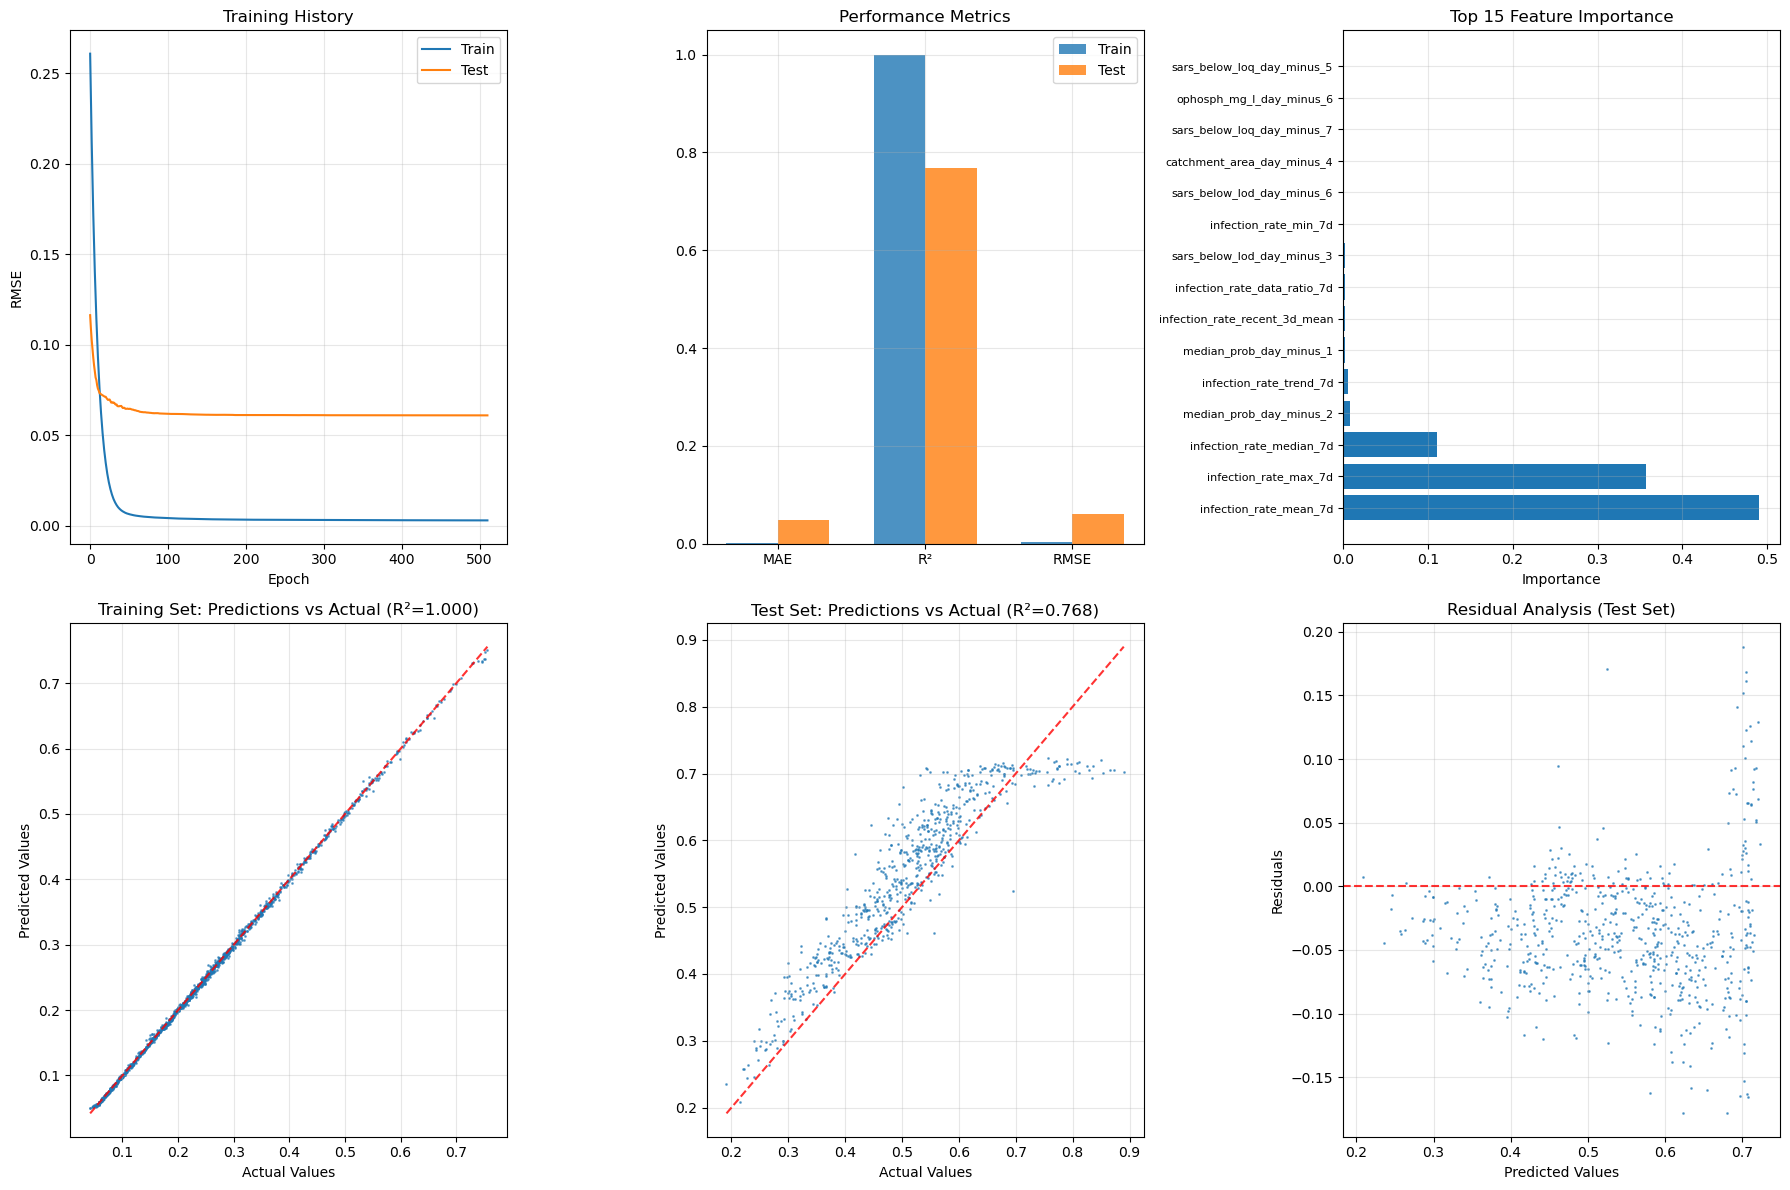


Save model and results...
Model and results saved

XGBoost model training completed (flexible time window + include past 7-day infection rate features + derived features)
Feature composition:
  - Time series features: 16 features/day × 7 days = 112 features
    * Original wastewater features: 15 features/day
    * History infection rate features: 1 feature/day
  - Availability flags: 7 flags
  - Derived features: 8 features
  - Total features: 127 features

Derived features description:
  ✓ Statistical features of the last 7 days of infection rates (mean, standard deviation, maximum, minimum, median)
  ✓ Trend feature of the last 7 days of infection rates
  ✓ Mean of the last 3 days of infection rates
  ✓ Data availability ratio of the last 7 days

Core strategy:
  ✓ Prediction day starts from the 8th day of the data, ensure a complete history window
  ✓ Strict 7-day time window, do not use data from the prediction day
  ✓ Flexible handling of missing data, use 0 to fill to maintain t

In [3]:
##### XGBoost version 3 - Include past 7-day infection rate features + infection rate derived features

print("=== XGBoost version 3 - Include past 7-day infection rate features + infection rate derived features ===")

# 1. Data loading
print("\n1. Loading data...")
data = pd.read_csv('../data/processed/london_data_transformed.csv')

# Data preprocessing
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(['CIS20CD', 'date']).reset_index(drop=True)

print(f"Data shape: {data.shape}")
print(f"Time range: {data['date'].min()} to {data['date'].max()}")

# Get CIS regions
cis_regions = data['CIS20CD'].unique()
print(f"Number of CIS regions: {len(cis_regions)}")

# Original features (15 features)
original_features = [
    'sars_cov2_gc_l_mean', 'suspended_solids_mg_l', 'ammonia_mg_l', 'ophosph_mg_l',
    'sample_ph_pre_ansis', 'control_gc_l_mean', 'raw_ansis_sars_repc_std',
    'grab_compo_boo', 'sars_below_lod', 'sars_below_loq', 'reception_delay',
    'catchment_population_ons_mid_2019', 'catchment_area', 'catch_in_cis_prop',
    'catch_cis_population'
]

print(f"\nOriginal features ({len(original_features)} features):")
for i, feat in enumerate(original_features, 1):
    print(f"  {i:2d}. {feat}")

# 2. Prepare flexible time window data (include past 7-day infection rate features + derived features)
print("\n2. Build flexible time window data set (include infection rate derived features)...")

def create_flexible_time_window_xgboost_with_infection_rates_derived(data, window_days=7):
    """
    Create flexible time window data set, including:
    - Original features (15 features) in the past window_days days
    - Infection rate data (1 feature) in the past window_days days
    - Derived features based on past 7-day infection rates (8 features)
    - Target: infection rate of the prediction day
    
    Core strategy:
    1. The prediction day must start from the 8th day of the data
    2. Each prediction day needs to have a complete 7-day history window
    3. If there is data, use it, otherwise use 0 to fill
    4. Never use data from the prediction day or future
    5. Derived features are completely based on the past 7-day infection rates
    """
    
    X_list = []
    y_list = []
    date_list = []
    cis_list = []
    availability_stats = {
        'total_potential_pred_days': 0,  # Total days in the data
        'valid_pred_days': 0,            # Predict days that meet the time window requirement
        'actual_pred_days': 0,           # Actual days used as prediction days (with data)
        'total_samples': 0,              # Total number of samples
        'total_hist_days': 0,            # Total days in the history window
        'available_hist_days': 0         # Days with data in the history window
    }
    
    # Get the time range of the global data
    global_min_date = data['date'].min()
    global_max_date = data['date'].max()
    earliest_pred_date = global_min_date + pd.Timedelta(days=window_days)
    
    print(f"Time range analysis:")
    print(f"  Earliest date in the data: {global_min_date.strftime('%Y-%m-%d')}")
    print(f"  Latest date in the data: {global_max_date.strftime('%Y-%m-%d')}")
    print(f"  Earliest date for prediction: {earliest_pred_date.strftime('%Y-%m-%d')} (Day {window_days+1})")
    
    # Get all CIS regions
    all_cis = sorted(data['CIS20CD'].unique())
    
    # Group by CIS region
    for cis in all_cis:
        cis_data = data[data['CIS20CD'] == cis].copy()
        cis_data = cis_data.sort_values('date').reset_index(drop=True)
        
        if len(cis_data) == 0:
            continue
            
        availability_stats['total_potential_pred_days'] += len(cis_data)
        
        # Create a mapping from date to data, for quick lookup
        cis_date_data = {}
        for _, row in cis_data.iterrows():
            cis_date_data[row['date'].date()] = row
        
        # Get the time range of the CIS region
        cis_min_date = cis_data['date'].min()
        cis_max_date = cis_data['date'].max()
        cis_earliest_pred_date = cis_min_date + pd.Timedelta(days=window_days)
        
        # Iterate through all possible prediction dates for this CIS region
        # Start from the 8th day of the CIS region, to the last day
        current_date = cis_earliest_pred_date
        while current_date <= cis_max_date:
            availability_stats['valid_pred_days'] += 1
            
            # Check if the current date has data (can be used as a prediction day)
            if current_date.date() in cis_date_data:
                pred_target = cis_date_data[current_date.date()]['median_prob']
                availability_stats['actual_pred_days'] += 1

                # Build a strict 7-day history window (before the prediction day)
                feature_vector = []
                availability_flags = []
                historical_infection_rates = []  # Store historical infection rates for calculating derived features
                
                for days_back in range(1, window_days + 1):  # 1-7 days before the prediction day
                    hist_date = (current_date - pd.Timedelta(days=days_back)).date()
                    
                    if hist_date in cis_date_data:
                        # There is data: use the real value
                        hist_row = cis_date_data[hist_date]
                        # Original features (15 features) + infection rate (1 feature) = 16 features
                        for feature in original_features:
                            feature_vector.append(hist_row[feature])
                        # Add historical infection rate
                        feature_vector.append(hist_row['median_prob'])
                        historical_infection_rates.append(hist_row['median_prob'])
                        availability_flags.append(1)  # Mark as having data
                        availability_stats['available_hist_days'] += 1
                    else:
                        # No data: use 0 to fill
                        for feature in original_features:
                            feature_vector.append(0.0)
                        # Infection rate also use 0 to fill
                        feature_vector.append(0.0)
                        historical_infection_rates.append(0.0)
                        availability_flags.append(0)  # Mark as having no data
                    
                    availability_stats['total_hist_days'] += 1
                
                # Calculate infection rate derived features (based on past 7-day historical infection rates)
                infection_derived_features = []
                
                # Convert list to numpy array for easier calculation
                hist_rates = np.array(historical_infection_rates)
                valid_rates = hist_rates[hist_rates > 0]  # Only consider valid (non-0) data
                
                if len(valid_rates) > 0:
                    # 1. Mean of valid data
                    infection_derived_features.append(np.mean(valid_rates))
                    # 2. Standard deviation of valid data
                    infection_derived_features.append(np.std(valid_rates) if len(valid_rates) > 1 else 0.0)
                    # 3. Maximum value of valid data
                    infection_derived_features.append(np.max(valid_rates))
                    # 4. Minimum value of valid data
                    infection_derived_features.append(np.min(valid_rates))
                    # 5. Median of valid data
                    infection_derived_features.append(np.median(valid_rates))
                    # 6. Trend of infection rates from the last day to the first day (last day - first day)
                    if len(valid_rates) >= 2:
                        # Find the earliest and latest valid data
                        last_valid_idx = len(hist_rates) - 1
                        while last_valid_idx >= 0 and hist_rates[last_valid_idx] == 0:
                            last_valid_idx -= 1
                        first_valid_idx = 0
                        while first_valid_idx < len(hist_rates) and hist_rates[first_valid_idx] == 0:
                            first_valid_idx += 1
                        
                        if last_valid_idx > first_valid_idx:
                            trend = hist_rates[last_valid_idx] - hist_rates[first_valid_idx]
                            infection_derived_features.append(trend)
                        else:
                            infection_derived_features.append(0.0)
                    else:
                        infection_derived_features.append(0.0)
                    # 7. Mean of the last 3 days (if there is any)
                    recent_rates = hist_rates[-3:]  # Last 3 days
                    valid_recent = recent_rates[recent_rates > 0]
                    if len(valid_recent) > 0:
                        infection_derived_features.append(np.mean(valid_recent))
                    else:
                        infection_derived_features.append(0.0)
                    # 8. Ratio of valid data in the last 7 days
                    infection_derived_features.append(len(valid_rates) / window_days)
                else:
                    # If there is no valid data, set all derived features to 0
                    infection_derived_features = [0.0] * 8
                
                # Add data availability flags as additional features
                feature_vector.extend(availability_flags)
                
                # Add infection rate derived features
                feature_vector.extend(infection_derived_features)
                
                X_list.append(feature_vector)
                y_list.append(pred_target)
                date_list.append(current_date)
                cis_list.append(cis)
                availability_stats['total_samples'] += 1
            
            # Move to the next day
            current_date += pd.Timedelta(days=1)
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    # Create feature names
    feature_names = []
    
    # Time series feature names (original features + infection rate)
    for day in range(1, window_days + 1):
        for feature in original_features:
            feature_names.append(f"{feature}_day_minus_{day}")
        feature_names.append(f"median_prob_day_minus_{day}")
    
    # Data availability flags
    for day in range(1, window_days + 1):
        feature_names.append(f"data_available_day_minus_{day}")
    
    # Infection rate derived feature names
    derived_feature_names = [
        'infection_rate_mean_7d',
        'infection_rate_std_7d', 
        'infection_rate_max_7d',
        'infection_rate_min_7d',
        'infection_rate_median_7d',
        'infection_rate_trend_7d',
        'infection_rate_recent_3d_mean',
        'infection_rate_data_ratio_7d'
    ]
    feature_names.extend(derived_feature_names)
    
    # Print detailed data availability statistics
    print(f"\n=== Data availability statistics ===")
    print(f"Prediction day statistics:")
    print(f"  Total days in the data: {availability_stats['total_potential_pred_days']}")
    print(f"  Days that meet the time window requirement: {availability_stats['valid_pred_days']}")
    print(f"  Actual days with data: {availability_stats['actual_pred_days']}")
    print(f"  Prediction day utilization: {availability_stats['actual_pred_days']/availability_stats['valid_pred_days']*100:.1f}%")
    
    print(f"\nHistory window statistics:")
    print(f"  Total days in the history window: {availability_stats['total_hist_days']}")
    print(f"  Days with data in the history window: {availability_stats['available_hist_days']}")
    print(f"  History data coverage: {availability_stats['available_hist_days']/availability_stats['total_hist_days']*100:.1f}%")
    print(f"  Average number of valid history days per sample: {availability_stats['available_hist_days']/availability_stats['total_samples']:.1f}/7 days")
    
    print(f"\nSample statistics:")
    print(f"  Total samples: {availability_stats['total_samples']}")
    print(f"  Average number of samples per CIS region: {availability_stats['total_samples']/len(all_cis):.1f}")
    
    print(f"\nFeature statistics:")
    print(f"  Feature dimension: {X.shape[1]}")
    print(f"  Time series features: {len(original_features) + 1} × {window_days} = {(len(original_features) + 1) * window_days}")
    print(f"  Availability flags: {window_days}")
    print(f"  Infection rate derived features: {len(derived_feature_names)}")
    print(f"  Total features: {(len(original_features) + 1) * window_days + window_days + len(derived_feature_names)}")
    
    return X, y, np.array(date_list), np.array(cis_list), feature_names

# Create data set
X, y, sample_dates, sample_cis, feature_names = create_flexible_time_window_xgboost_with_infection_rates_derived(
    data, window_days=7
)

print(f"\n=== Data set shape ===")
print(f"  Feature matrix: {X.shape}")
print(f"  Target vector: {y.shape}")
print(f"  Total samples: {len(y)}")

# Feature composition
print(f"\n=== Feature composition ===")
print(f"Time series features (for each sample):")
print(f"  - 1 day before: 15 features + 1 feature = 16 features")
print(f"  - 2 days before: 15 features + 1 feature = 16 features")
print(f"  - 3 days before: 15 features + 1 feature = 16 features")
print(f"  - 4 days before: 15 features + 1 feature = 16 features")
print(f"  - 5 days before: 15 features + 1 feature = 16 features")
print(f"  - 6 days before: 15 features + 1 feature = 16 features")
print(f"  - 7 days before: 15 features + 1 feature = 16 features")
print(f"  - Total: 16 features × 7 days = 112 features")

print(f"\nData availability flags:")
print(f"  - 7 flags (1=data available, 0=no data)")

print(f"\nInfection rate derived features:")
print(f"  1. infection_rate_mean_7d: Mean of infection rates in the last 7 days")
print(f"  2. infection_rate_std_7d: Standard deviation of infection rates in the last 7 days")
print(f"  3. infection_rate_max_7d: Maximum value of infection rates in the last 7 days")
print(f"  4. infection_rate_min_7d: Minimum value of infection rates in the last 7 days")
print(f"  5. infection_rate_median_7d: Median value of infection rates in the last 7 days")
print(f"  6. infection_rate_trend_7d: Trend of infection rates in the last 7 days (latest - earliest)")
print(f"  7. infection_rate_recent_3d_mean: Mean of the last 3 days of infection rates")
print(f"  8. infection_rate_data_ratio_7d: Ratio of valid data in the last 7 days")
print(f"  - Total: 8 derived features")

print(f"\nTotal features: 112 + 7 + 8 = 127")

print(f"\n=== Strategy validation ===")
print(f"✓ Prediction day selection: Start from the 8th day of the data, ensuring a complete history window")
print(f"✓ History window: Strict 7-day time window (1-7 days before the prediction day)")
print(f"✓ Missing data handling: Use 0 to fill in the history window if there is no data")
print(f"✓ Time boundary: Never use data from the prediction day or future days")
print(f"✓ Feature completeness: Include original features + historical infection rates + infection rate derived features")
print(f"✓ Derived features: Fully based on the last 7 days of infection rates")

# Example of time logic validation
print(f"\n=== Example of time logic validation ===")
if len(sample_dates) > 0:
    # Show the time logic for the first 3 samples
    for i in range(min(3, len(sample_dates))):
        sample_pred_date = sample_dates[i]
        print(f"Sample {i}:")
        print(f"  Prediction day: {sample_pred_date.strftime('%Y-%m-%d')}")
        print(f"  History window: {(sample_pred_date - pd.Timedelta(days=7)).strftime('%Y-%m-%d')} to {(sample_pred_date - pd.Timedelta(days=1)).strftime('%Y-%m-%d')}")
        print(f"  Prediction target: {y[i]:.4f}")
        print(f"  CIS region: {sample_cis[i]}")
        print(f"  Data availability: {X[i, 112:119].astype(int)}")  # The 112-118th features are the availability flags
        print(f"  Derived feature examples:")
        print(f"    - Mean of the last 7 days: {X[i, 119]:.4f}")
        print(f"    - Standard deviation of the last 7 days: {X[i, 120]:.4f}")
        print(f"    - Trend of the last 7 days: {X[i, 124]:.4f}")
        print(f"    - Data availability ratio: {X[i, 126]:.4f}")
        print()

# Validate no future data is used
print(f"=== Time safety validation ===")
min_pred_date = sample_dates.min()
max_pred_date = sample_dates.max()
print(f"Prediction date range: {min_pred_date.strftime('%Y-%m-%d')} to {max_pred_date.strftime('%Y-%m-%d')}")
print(f"Earliest prediction day distance to data start: {(min_pred_date - data['date'].min()).days} days")
print(f"✓ Confirm: The earliest prediction day is at least 8 days after the start of the data")

# Time split
print("\nTime split...")
sample_dates_dt = pd.to_datetime(sample_dates)
sorted_dates = sorted(sample_dates_dt.unique())
split_idx = int(len(sorted_dates) * 0.7)
split_date = sorted_dates[split_idx]

train_mask = sample_dates_dt <= split_date
test_mask = sample_dates_dt > split_date

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"Training set: {len(y_train)} samples")
print(f"Test set: {len(y_test)} samples")
print(f"Split date: {split_date}")

# Feature standardization
print("\nFeature standardization...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature standardization completed")

# XGBoost model training
print("\nXGBoost model training...")

# Model parameters
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 1,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42,
    'n_jobs': -1
}

print("Model parameters:")
for key, value in params.items():
    print(f"  {key}: {value}")

# Train model
model = xgb.XGBRegressor(**params)

# Use early stopping mechanism
model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
    eval_metric='rmse',
    early_stopping_rounds=50,
    verbose=False
)

print(f"Training completed, best iteration: {model.best_iteration}")

# Model prediction and evaluation
print("\nModel prediction and evaluation...")

# Prediction
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Calculate metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("=== Model performance ===")
print(f"Training set:")
print(f"  MAE: {train_mae:.4f}")
print(f"  R²: {train_r2:.4f}")
print(f"  RMSE: {train_rmse:.4f}")

print(f"\nTest set:")
print(f"  MAE: {test_mae:.4f}")
print(f"  R²: {test_r2:.4f}")
print(f"  RMSE: {test_rmse:.4f}")

# Feature importance analysis
print("\nFeature importance analysis...")

# Get feature importance
feature_importance = model.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nTop 20 most important features:")
print(importance_df.head(20).to_string(index=False))

# Analyze the importance of different types of features
time_features_importance = importance_df[
    ~importance_df['feature'].str.contains('data_available') & 
    ~importance_df['feature'].str.contains('infection_rate_')
]['importance'].sum()

availability_features_importance = importance_df[
    importance_df['feature'].str.contains('data_available')
]['importance'].sum()

derived_features_importance = importance_df[
    importance_df['feature'].str.contains('infection_rate_')
]['importance'].sum()

# Analyze the importance of original features vs infection rate features
original_features_importance = importance_df[
    importance_df['feature'].str.contains('|'.join(original_features))
]['importance'].sum()

infection_rate_features_importance = importance_df[
    importance_df['feature'].str.contains('median_prob_day_minus')
]['importance'].sum()

print(f"\nFeature type importance:")
print(f"  Time series features total importance: {time_features_importance:.4f}")
print(f"    - Original features importance: {original_features_importance:.4f}")
print(f"    - Infection rate features importance: {infection_rate_features_importance:.4f}")
print(f"  Availability flags total importance: {availability_features_importance:.4f}")
print(f"  Derived features total importance: {derived_features_importance:.4f}")

total_importance = time_features_importance + availability_features_importance + derived_features_importance

print(f"\nFeature importance ratio:")
print(f"  Original features importance ratio: {original_features_importance/total_importance*100:.1f}%")
print(f"  Infection rate features importance ratio: {infection_rate_features_importance/total_importance*100:.1f}%")
print(f"  Availability flags importance ratio: {availability_features_importance/total_importance*100:.1f}%")
print(f"  Derived features importance ratio: {derived_features_importance/total_importance*100:.1f}%")

# Analyze the importance of derived features
print(f"\nDerived features detailed importance:")
derived_features_detail = importance_df[importance_df['feature'].str.contains('infection_rate_')].sort_values('importance', ascending=False)
for _, row in derived_features_detail.iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

# Result visualization
print("\nResult visualization...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Training history
evals_result = model.evals_result()
epochs = len(evals_result['validation_0']['rmse'])
x_axis = range(0, epochs)

axes[0, 0].plot(x_axis, evals_result['validation_0']['rmse'], label='Train')
axes[0, 0].plot(x_axis, evals_result['validation_1']['rmse'], label='Test')
axes[0, 0].set_title('Training History')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Performance metrics comparison
metrics = ['MAE', 'R²', 'RMSE']
train_vals = [train_mae, train_r2, train_rmse]
test_vals = [test_mae, test_r2, test_rmse]

x = np.arange(len(metrics))
width = 0.35

axes[0, 1].bar(x - width/2, train_vals, width, label='Train', alpha=0.8)
axes[0, 1].bar(x + width/2, test_vals, width, label='Test', alpha=0.8)
axes[0, 1].set_title('Performance Metrics')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(metrics)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Feature importance (top 15)
top_features = importance_df.head(15)
axes[0, 2].barh(range(len(top_features)), top_features['importance'])
axes[0, 2].set_yticks(range(len(top_features)))
axes[0, 2].set_yticklabels(top_features['feature'], fontsize=8)
axes[0, 2].set_title('Top 15 Feature Importance')
axes[0, 2].set_xlabel('Importance')
axes[0, 2].grid(True, alpha=0.3)

# Predicted vs actual scatter plot - training set
axes[1, 0].scatter(y_train, y_train_pred, alpha=0.6, s=1)
axes[1, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', alpha=0.8)
axes[1, 0].set_title(f'Training Set: Predictions vs Actual (R²={train_r2:.3f})')
axes[1, 0].set_xlabel('Actual Values')
axes[1, 0].set_ylabel('Predicted Values')
axes[1, 0].grid(True, alpha=0.3)

# Predicted vs actual scatter plot - test set
axes[1, 1].scatter(y_test, y_test_pred, alpha=0.6, s=1)
axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', alpha=0.8)
axes[1, 1].set_title(f'Test Set: Predictions vs Actual (R²={test_r2:.3f})')
axes[1, 1].set_xlabel('Actual Values')
axes[1, 1].set_ylabel('Predicted Values')
axes[1, 1].grid(True, alpha=0.3)

# Residual analysis
test_residuals = y_test - y_test_pred
axes[1, 2].scatter(y_test_pred, test_residuals, alpha=0.6, s=1)
axes[1, 2].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[1, 2].set_title('Residual Analysis (Test Set)')
axes[1, 2].set_xlabel('Predicted Values')
axes[1, 2].set_ylabel('Residuals')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/xgboost_version_3_with_infection_rates_derived.png', dpi=300, bbox_inches='tight')
plt.show()

# Save model and results
print("\nSave model and results...")

# Save model
model.save_model('../models/xgboost_version_3_with_infection_rates_derived.json')

# Save feature importance
importance_df.to_csv('../results/xgboost_version_3_derived_feature_importance.csv', index=False)

# Save predictions
results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_test_pred,
    'residual': y_test - y_test_pred,
    'date': sample_dates[test_mask],
    'cis_code': sample_cis[test_mask]
})
results_df.to_csv('../results/xgboost_version_3_predictions.csv', index=False)

print("Model and results saved")

print("\n" + "="*80)
print("XGBoost model training completed (flexible time window + include past 7-day infection rate features + derived features)")
print("="*80)
print(f"Feature composition:")
print(f"  - Time series features: 16 features/day × 7 days = 112 features")
print(f"    * Original wastewater features: {len(original_features)} features/day")
print(f"    * History infection rate features: 1 feature/day")
print(f"  - Availability flags: 7 flags")
print(f"  - Derived features: 8 features")
print(f"  - Total features: 127 features")
print(f"\nDerived features description:")
print(f"  ✓ Statistical features of the last 7 days of infection rates (mean, standard deviation, maximum, minimum, median)")
print(f"  ✓ Trend feature of the last 7 days of infection rates")
print(f"  ✓ Mean of the last 3 days of infection rates")
print(f"  ✓ Data availability ratio of the last 7 days")
print(f"\nCore strategy:")
print(f"  ✓ Prediction day starts from the 8th day of the data, ensure a complete history window")
print(f"  ✓ Strict 7-day time window, do not use data from the prediction day")
print(f"  ✓ Flexible handling of missing data, use 0 to fill to maintain time logic")
print(f"  ✓ Include infection rate data for each day in the past 7 days")
print(f"  ✓ Include derived features based on historical infection rates")
print(f"  ✓ Include original wastewater detection features")
print(f"  ✓ Include data availability flags to help the model identify valid data")
print(f"\nFinal performance:")
print(f"  ✓ Test set MAE: {test_mae:.4f}")
print(f"  ✓ Test set R²: {test_r2:.4f}")
print(f"  ✓ Test set RMSE: {test_rmse:.4f}")
print(f"\nFeature contribution:")
print(f"  ✓ Original features importance ratio: {original_features_importance/total_importance*100:.1f}%")
print(f"  ✓ Infection rate features importance ratio: {infection_rate_features_importance/total_importance*100:.1f}%")
print(f"  ✓ Derived features importance ratio: {derived_features_importance/total_importance*100:.1f}%")
print(f"  ✓ Availability flags importance ratio: {availability_features_importance/total_importance*100:.1f}%")
print("="*80)

=== XGBoost version 4 - Include past 7-day infection rate features + derived features + socio-economic features ===

1. Load data...
Data shape: (2398, 20)
Time range: 2020-09-04 00:00:00 to 2021-02-10 00:00:00
CIS region number: 27
Matching CIS regions: 27

Original features (15 features):
   1. sars_cov2_gc_l_mean
   2. suspended_solids_mg_l
   3. ammonia_mg_l
   4. ophosph_mg_l
   5. sample_ph_pre_ansis
   6. control_gc_l_mean
   7. raw_ansis_sars_repc_std
   8. grab_compo_boo
   9. sars_below_lod
  10. sars_below_loq
  11. reception_delay
  12. catchment_population_ons_mid_2019
  13. catchment_area
  14. catch_in_cis_prop
  15. catch_cis_population

Socio-economic features (5 features):
  1. IMD_Score
  2. Population_Density
  3. Elderly_Ratio
  4. Overcrowding_Rate
  5. Ethnic_Diversity_Index

2. Build flexible time window dataset (include infection rate derived features)...
Time range analysis:
  Earliest date: 2020-09-04
  Latest date: 2021-02-10
  Earliest predict date: 2020-09

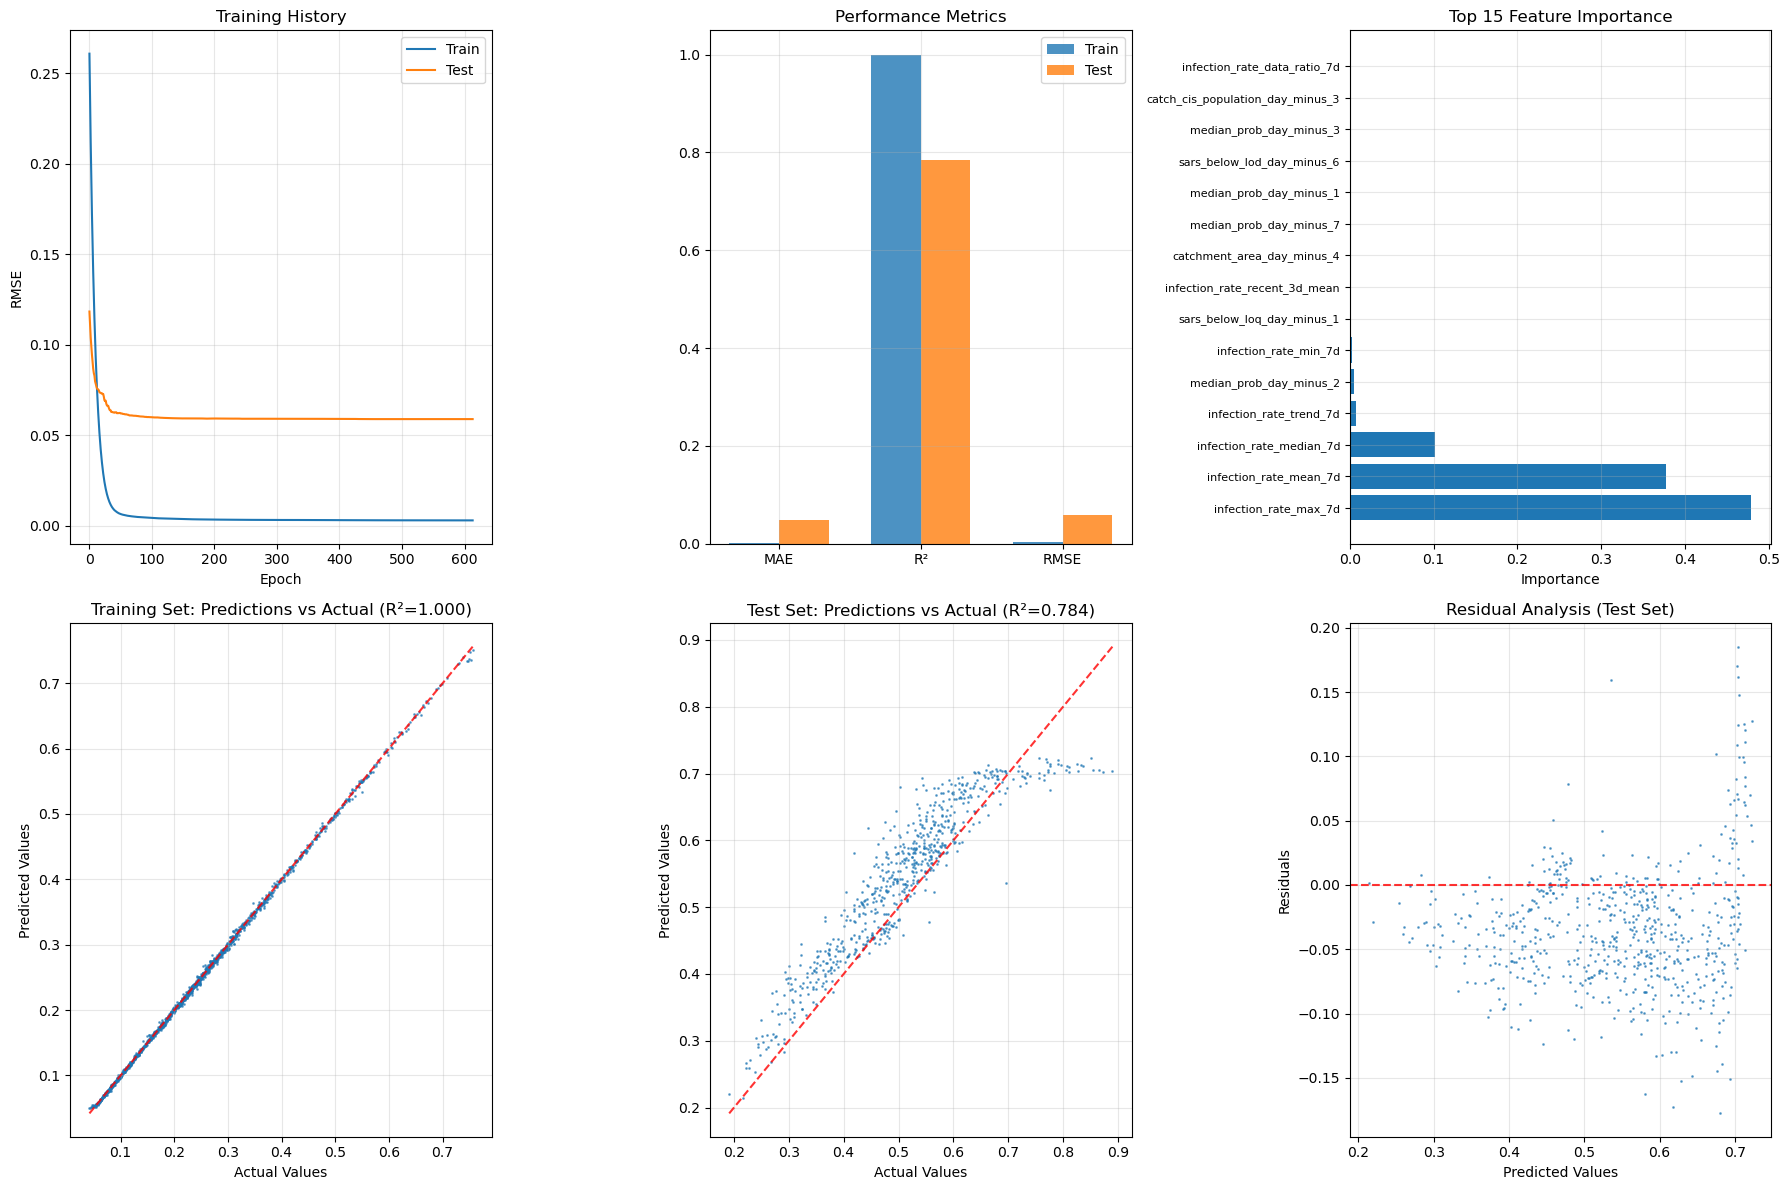


9. Save model and results...
Model and results saved

XGBoost model training completed (flexible time window + include past 7-day infection rate features + derived features + socio-economic features)
Feature composition:
  - Time series features: 16 features/day × 7 days = 112 features
    * Original wastewater features: 15 features/day
    * History infection rate features: 1 feature/day
  - Availability flags: 7 flags
  - Infection rate derived features: 8 features
  - Socio-economic features: 5 features (static)
  - Total features: 132 features

Derived features description:
  ✓ Statistical features of the last 7 days of infection rates (mean, standard deviation, maximum, minimum, median)
  ✓ Infection rate trend feature
  ✓ Recent 3-day infection rate mean
  ✓ Data availability ratio of the last 7 days

Core strategy:
  ✓ Prediction day starts from the 8th day of the data, ensure a complete history window
  ✓ Strict 7-day time window, do not use data from the prediction day
  ✓ Fl

In [4]:
##### XGBoost version 4 - Include past 7-day infection rate features + derived features + socio-economic features

print("=== XGBoost version 4 - Include past 7-day infection rate features + derived features + socio-economic features ===")

# 1. Load data
print("\n1. Load data...")
data = pd.read_csv('../data/processed/london_data_transformed.csv')
socio_data = pd.read_csv('../data/processed/cis_socio_economic_data.csv')

# Data preprocessing
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(['CIS20CD', 'date']).reset_index(drop=True)

print(f"Data shape: {data.shape}")
print(f"Time range: {data['date'].min()} to {data['date'].max()}")

# Get CIS regions
cis_regions = data['CIS20CD'].unique()
socio_cis = socio_data['CIS20CD'].unique()
common_cis = set(cis_regions) & set(socio_cis)

print(f"CIS region number: {len(cis_regions)}")
print(f"Matching CIS regions: {len(common_cis)}")

# Original features (15 features)
original_features = [
    'sars_cov2_gc_l_mean', 'suspended_solids_mg_l', 'ammonia_mg_l', 'ophosph_mg_l',
    'sample_ph_pre_ansis', 'control_gc_l_mean', 'raw_ansis_sars_repc_std',
    'grab_compo_boo', 'sars_below_lod', 'sars_below_loq', 'reception_delay',
    'catchment_population_ons_mid_2019', 'catchment_area', 'catch_in_cis_prop',
    'catch_cis_population'
]

# Socio-economic features (5 features)
socio_features = ['IMD_Score', 'Population_Density', 'Elderly_Ratio', 'Overcrowding_Rate', 'Ethnic_Diversity_Index']

print(f"\nOriginal features ({len(original_features)} features):")
for i, feat in enumerate(original_features, 1):
    print(f"  {i:2d}. {feat}")

print(f"\nSocio-economic features ({len(socio_features)} features):")
for i, feat in enumerate(socio_features, 1):
    print(f"  {i}. {feat}")

# 2. Flexible time window data preparation (include past 7-day infection rate features + derived features + socio-economic features)
print("\n2. Build flexible time window dataset (include infection rate derived features)...")

def create_flexible_time_window_xgboost_with_all_features_derived(data, socio_data, window_days=7):
    """
    Create flexible time window dataset, include:
    - Original features (15 features) within the last window_days days
    - Infection rate data (1 feature) within the last window_days days
    - Derived features (8 features) based on the last 7 days of infection rates
    - Socio-economic features (5 features, static)
    - Target: infection rate of the prediction day
    
    Core strategy:
    1. Prediction day must start from the 8th day of the data
    2. Each prediction day needs to have a complete 7-day history window
    3. Use data if available, otherwise use 0 to fill
    4. Never use data from the prediction day or future
    5. Derived features are completely based on the last 7 days of infection rates
    """
    
    X_list = []
    y_list = []
    date_list = []
    cis_list = []
    availability_stats = {
        'total_potential_pred_days': 0,  # Total days in the data
        'valid_pred_days': 0,            # Predict days that meet the time window requirement
        'actual_pred_days': 0,           # Actual days used for prediction (with data)
        'total_samples': 0,              # Total number of samples
        'total_hist_days': 0,            # Total days in the history window
        'available_hist_days': 0         # Days with data in the history window
    }
    
    # Get the time range of the global data
    global_min_date = data['date'].min()
    global_max_date = data['date'].max()
    earliest_pred_date = global_min_date + pd.Timedelta(days=window_days)
    
    print(f"Time range analysis:")
    print(f"  Earliest date: {global_min_date.strftime('%Y-%m-%d')}")
    print(f"  Latest date: {global_max_date.strftime('%Y-%m-%d')}")
    print(f"  Earliest predict date: {earliest_pred_date.strftime('%Y-%m-%d')} (Day {window_days+1})")
    
    # Get CIS regions with matching socio-economic data
    all_cis = sorted(list(common_cis))
    
    # Group by CIS region
    for cis in all_cis:
        cis_data = data[data['CIS20CD'] == cis].copy()
        cis_data = cis_data.sort_values('date').reset_index(drop=True)
        
        if len(cis_data) == 0:
            continue
            
        availability_stats['total_potential_pred_days'] += len(cis_data)
        
        # Get socio-economic features
        socio_row = socio_data[socio_data['CIS20CD'] == cis]
        if len(socio_row) == 0:
            continue
            
        socio_vec = socio_row[socio_features].values[0]
        
        # Create a mapping from date to data, for fast lookup
        cis_date_data = {}
        for _, row in cis_data.iterrows():
            cis_date_data[row['date'].date()] = row
        
        # Get the time range of the CIS region
        cis_min_date = cis_data['date'].min()
        cis_max_date = cis_data['date'].max()
        cis_earliest_pred_date = cis_min_date + pd.Timedelta(days=window_days)
        
        # Iterate through all possible prediction dates for this CIS region
        # Start from the 8th day of the CIS region, until the last day
        current_date = cis_earliest_pred_date
        while current_date <= cis_max_date:
            availability_stats['valid_pred_days'] += 1
            
            # Check if the current date has data (can be used as a prediction day)
            if current_date.date() in cis_date_data:
                pred_target = cis_date_data[current_date.date()]['median_prob']
                availability_stats['actual_pred_days'] += 1
                
                # Build a strict 7-day history window (before the prediction day)
                feature_vector = []
                availability_flags = []
                historical_infection_rates = []  # Store historical infection rates for derived features
                
                for days_back in range(1, window_days + 1):  # 1-7 days ago
                    hist_date = (current_date - pd.Timedelta(days=days_back)).date()
                    
                    if hist_date in cis_date_data:
                        # Data available: use real value
                        hist_row = cis_date_data[hist_date]
                        # Original features (15 features) + infection rate (1 feature) = 16 features
                        for feature in original_features:
                            feature_vector.append(hist_row[feature])
                        # Add historical infection rate
                        feature_vector.append(hist_row['median_prob'])
                        historical_infection_rates.append(hist_row['median_prob'])
                        availability_flags.append(1)  # Mark as data available
                        availability_stats['available_hist_days'] += 1
                    else:
                        # No data: use 0
                        for feature in original_features:
                            feature_vector.append(0.0)
                        # Infection rate also use 0
                        feature_vector.append(0.0)
                        historical_infection_rates.append(0.0)
                        availability_flags.append(0)  # Mark as no data
                    
                    availability_stats['total_hist_days'] += 1
                
                # Add data availability flags as additional features
                feature_vector.extend(availability_flags)
                
                # Calculate infection rate derived features (based on the last 7 days of infection rates)
                infection_derived_features = []
                
                # Convert list to numpy array for calculation
                hist_rates = np.array(historical_infection_rates)
                valid_rates = hist_rates[hist_rates > 0]  # Only consider valid (non-0) data
                
                if len(valid_rates) > 0:
                    # 1. Mean of valid data
                    infection_derived_features.append(np.mean(valid_rates))
                    # 2. Standard deviation of valid data
                    infection_derived_features.append(np.std(valid_rates) if len(valid_rates) > 1 else 0.0)
                    # 3. Maximum of valid data
                    infection_derived_features.append(np.max(valid_rates))
                    # 4. Minimum of valid data
                    infection_derived_features.append(np.min(valid_rates))
                    # 5. Median of valid data
                    infection_derived_features.append(np.median(valid_rates))
                    # 6. Trend of infection rates (last day - first day)
                    if len(valid_rates) >= 2:
                        # Find the earliest and latest valid data
                        last_valid_idx = len(hist_rates) - 1
                        while last_valid_idx >= 0 and hist_rates[last_valid_idx] == 0:
                            last_valid_idx -= 1
                        first_valid_idx = 0
                        while first_valid_idx < len(hist_rates) and hist_rates[first_valid_idx] == 0:
                            first_valid_idx += 1
                        
                        if last_valid_idx > first_valid_idx:
                            trend = hist_rates[last_valid_idx] - hist_rates[first_valid_idx]
                            infection_derived_features.append(trend)
                        else:
                            infection_derived_features.append(0.0)
                    else:
                        infection_derived_features.append(0.0)
                    # 7. Mean of the last 3 days (if available)
                    recent_rates = hist_rates[-3:]  # Last 3 days
                    valid_recent = recent_rates[recent_rates > 0]
                    if len(valid_recent) > 0:
                        infection_derived_features.append(np.mean(valid_recent))
                    else:
                        infection_derived_features.append(0.0)
                    # 8. Ratio of valid data in the last 7 days
                    infection_derived_features.append(len(valid_rates) / window_days)
                else:
                    # If no valid data, set all derived features to 0
                    infection_derived_features = [0.0] * 8
                
                # Add infection rate derived features
                feature_vector.extend(infection_derived_features)
                
                # Add socio-economic features (static features)
                feature_vector.extend(socio_vec)
                
                X_list.append(feature_vector)
                y_list.append(pred_target)
                date_list.append(current_date)
                cis_list.append(cis)
                availability_stats['total_samples'] += 1
            
            # Move to the next day
            current_date += pd.Timedelta(days=1)
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    # Create feature names
    feature_names = []
    
    # Time series feature names (original features + infection rate)
    for day in range(1, window_days + 1):
        for feature in original_features:
            feature_names.append(f"{feature}_day_minus_{day}")
        feature_names.append(f"median_prob_day_minus_{day}")
    
    # Data availability flags
    for day in range(1, window_days + 1):
        feature_names.append(f"data_available_day_minus_{day}")
    
    # Infection rate derived feature names
    derived_feature_names = [
        'infection_rate_mean_7d',
        'infection_rate_std_7d', 
        'infection_rate_max_7d',
        'infection_rate_min_7d',
        'infection_rate_median_7d',
        'infection_rate_trend_7d',
        'infection_rate_recent_3d_mean',
        'infection_rate_data_ratio_7d'
    ]
    feature_names.extend(derived_feature_names)
    
    # Socio-economic features
    for feature in socio_features:
        feature_names.append(f"socio_{feature}")
    
    # Print detailed data availability statistics
    print(f"\n=== Data availability statistics ===")
    print(f"Prediction day statistics:")
    print(f"  Total days in the data: {availability_stats['total_potential_pred_days']}")
    print(f"  Days meeting the time window requirement: {availability_stats['valid_pred_days']}")
    print(f"  Actual days with data: {availability_stats['actual_pred_days']}")
    print(f"  Prediction day utilization: {availability_stats['actual_pred_days']/availability_stats['valid_pred_days']*100:.1f}%")
    
    print(f"\nHistory window statistics:")
    print(f"  Total history days: {availability_stats['total_hist_days']}")
    print(f"  Days with data: {availability_stats['available_hist_days']}")
    print(f"  History data coverage: {availability_stats['available_hist_days']/availability_stats['total_hist_days']*100:.1f}%")
    print(f"  Average number of valid history days per sample: {availability_stats['available_hist_days']/availability_stats['total_samples']:.1f}/7 days")
    
    print(f"\nSample statistics:")
    print(f"  Total samples: {availability_stats['total_samples']}")
    print(f"  Average number of samples per CIS region: {availability_stats['total_samples']/len(all_cis):.1f}")
    
    print(f"\nFeature statistics:")
    print(f"  Feature dimension: {X.shape[1]}")
    print(f"  Time series features: {(len(original_features) + 1)} × {window_days} = {(len(original_features) + 1) * window_days}")
    print(f"  Data availability flags: {window_days}")
    print(f"  Infection rate derived features: {len(derived_feature_names)}")
    print(f"  Socio-economic features: {len(socio_features)}")
    print(f"  Total features: {(len(original_features) + 1) * window_days + window_days + len(derived_feature_names) + len(socio_features)}")
    
    return X, y, np.array(date_list), np.array(cis_list), feature_names

# Create dataset
X, y, sample_dates, sample_cis, feature_names = create_flexible_time_window_xgboost_with_all_features_derived(
    data, socio_data, window_days=7
)

print(f"\n=== Dataset shape ===")
print(f"  Feature matrix: {X.shape}")
print(f"  Target vector: {y.shape}")
print(f"  Total samples: {len(y)}")

# Feature description
print(f"\n=== Feature composition ===")
print(f"Time series features (per sample):")
print(f"  - 15 original features + 1 infection rate = 16 features")
print(f"  - 15 original features + 1 infection rate = 16 features")
print(f"  - 15 original features + 1 infection rate = 16 features")
print(f"  - 16 × 7 = 112 time series features")

print(f"\nData availability flags:")
print(f"  - 7 flags (1=data available, 0=no data)")

print(f"\nInfection rate derived features:")
print(f"  1. infection_rate_mean_7d: Mean of the last 7 days of infection rates")
print(f"  2. infection_rate_std_7d: Standard deviation of the last 7 days of infection rates")
print(f"  3. infection_rate_max_7d: Maximum of the last 7 days of infection rates")
print(f"  4. infection_rate_min_7d: Minimum of the last 7 days of infection rates")
print(f"  5. infection_rate_median_7d: Median of the last 7 days of infection rates")
print(f"  6. infection_rate_trend_7d: Trend of the last 7 days of infection rates (last day - first day)")
print(f"  7. infection_rate_recent_3d_mean: Mean of the last 3 days of infection rates")
print(f"  8. infection_rate_data_ratio_7d: Ratio of valid data in the last 7 days")
print(f"  Subtotal: 8 derived features")

print(f"\nSocio-economic features (static):")
for i, feat in enumerate(socio_features, 1):
    print(f"  - {feat}")
print(f"  - {len(socio_features)} socio-economic features")

print(f"\nTotal features: 112 + 7 + 8 + {len(socio_features)} = {112 + 7 + 8 + len(socio_features)}")

print(f"\n=== Strategy validation ===")
print(f"✓ Prediction day selection: Start from the 8th day of the data, ensure a complete history window")
print(f"✓ Strict 7-day time window, do not use data from the prediction day")
print(f"✓ Flexible handling of missing data, use 0 to fill to maintain time logic")
print(f"✓ Include original wastewater detection features")
print(f"✓ Include infection rate data for each day in the past 7 days")
print(f"✓ Derived features: Fully based on the last 7 days of infection rates")

# Example of time logic validation
print(f"\n=== Time logic example ===")
if len(sample_dates) > 0:
    # Display the time logic of the first 3 samples
    for i in range(min(3, len(sample_dates))):
        sample_pred_date = sample_dates[i]
        print(f"Sample {i}:")
        print(f"  Prediction day: {sample_pred_date.strftime('%Y-%m-%d')}")
        print(f"  History window: {(sample_pred_date - pd.Timedelta(days=7)).strftime('%Y-%m-%d')} to {(sample_pred_date - pd.Timedelta(days=1)).strftime('%Y-%m-%d')}")
        print(f"  Prediction target: {y[i]:.4f}")
        print(f"  CIS region: {sample_cis[i]}")
        print(f"  Data availability: {X[i, 112:119].astype(int)}")  # The 112-118th features are data availability flags
        print(f"  Derived features example:")
        print(f"    - 7-day mean infection rate: {X[i, 119]:.4f}")
        print(f"    - 7-day infection rate standard deviation: {X[i, 120]:.4f}")
        print(f"    - 7-day infection rate trend: {X[i, 124]:.4f}")
        print(f"    - Data availability ratio: {X[i, 126]:.4f}")
        print(f"  Socio-economic features: {X[i, -5:]}")  # The last 5 features are socio-economic features
        print()

# Validate that no future data is used
print(f"=== Time safety validation ===")
min_pred_date = sample_dates.min()
max_pred_date = sample_dates.max()
print(f"Prediction date range: {min_pred_date.strftime('%Y-%m-%d')} to {max_pred_date.strftime('%Y-%m-%d')}")
print(f"Earliest prediction day distance from data start: {(min_pred_date - data['date'].min()).days} days")
print(f"✓ Confirm: Earliest prediction day is at least 8 days from the start of the data")

# 3. Time split
print("\n3. Time split...")
sample_dates_dt = pd.to_datetime(sample_dates)
sorted_dates = sorted(sample_dates_dt.unique())
split_idx = int(len(sorted_dates) * 0.7)
split_date = sorted_dates[split_idx]

train_mask = sample_dates_dt <= split_date
test_mask = sample_dates_dt > split_date

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"Training set: {len(y_train)} samples")
print(f"Test set: {len(y_test)} samples")
print(f"Split date: {split_date}")

# 4. Feature standardization
print("\n4. Feature standardization...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature standardization completed")

# 5. XGBoost model training
print("\n5. XGBoost model training...")

# Model parameters
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 1,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42,
    'n_jobs': -1
}

print("Model parameters:")
for key, value in params.items():
    print(f"  {key}: {value}")

# Train model
model = xgb.XGBRegressor(**params)

# Use early stopping mechanism
model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
    eval_metric='rmse',
    early_stopping_rounds=50,
    verbose=False
)

print(f"Training completed, best iteration: {model.best_iteration}")

# 6. Model prediction and evaluation
print("\n6. Model prediction and evaluation...")

# Prediction
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Calculate metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("=== Model performance ===")
print(f"Training set:")
print(f"  MAE: {train_mae:.4f}")
print(f"  R²: {train_r2:.4f}")
print(f"  RMSE: {train_rmse:.4f}")

print(f"\nTest set:")
print(f"  MAE: {test_mae:.4f}")
print(f"  R²: {test_r2:.4f}")
print(f"  RMSE: {test_rmse:.4f}")

# 7. Feature importance analysis
print("\n7. Feature importance analysis...")

# Get feature importance
feature_importance = model.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nTop 20 most important features:")
print(importance_df.head(20).to_string(index=False))

# Analyze the importance of different types of features
time_features_importance = importance_df[
    ~importance_df['feature'].str.contains('data_available') & 
    ~importance_df['feature'].str.contains('socio_') &
    ~importance_df['feature'].str.contains('infection_rate_')
]['importance'].sum()

availability_features_importance = importance_df[
    importance_df['feature'].str.contains('data_available')
]['importance'].sum()

socio_features_importance = importance_df[
    importance_df['feature'].str.contains('socio_')
]['importance'].sum()

derived_features_importance = importance_df[
    importance_df['feature'].str.contains('infection_rate_')
]['importance'].sum()

# Analyze the importance of original features vs infection rate features
original_features_importance = importance_df[
    importance_df['feature'].str.contains('|'.join(original_features))
]['importance'].sum()

infection_rate_features_importance = importance_df[
    importance_df['feature'].str.contains('median_prob_day_minus')
]['importance'].sum()

print(f"\nFeature type importance:")
print(f"  Time series features total importance: {time_features_importance:.4f}")
print(f"    - Original features importance: {original_features_importance:.4f}")
print(f"    - Infection rate features importance: {infection_rate_features_importance:.4f}")
print(f"  Availability flags total importance: {availability_features_importance:.4f}")
print(f"  Derived features total importance: {derived_features_importance:.4f}")
print(f"  Socio-economic features total importance: {socio_features_importance:.4f}")

total_importance = time_features_importance + availability_features_importance + derived_features_importance + socio_features_importance

print(f"\nFeature importance ratio:")
print(f"  Time series features ratio: {time_features_importance/total_importance*100:.1f}%")
print(f"    - Original features ratio: {original_features_importance/time_features_importance*100:.1f}%")
print(f"    - Infection rate features ratio: {infection_rate_features_importance/time_features_importance*100:.1f}%")
print(f"  Availability flags ratio: {availability_features_importance/total_importance*100:.1f}%")
print(f"  Derived features ratio: {derived_features_importance/total_importance*100:.1f}%")
print(f"  Socio-economic features ratio: {socio_features_importance/total_importance*100:.1f}%")

# Analyze the importance of derived features
print(f"\nInfection rate derived features detailed importance:")
derived_features_detail = importance_df[importance_df['feature'].str.contains('infection_rate_')].sort_values('importance', ascending=False)
for _, row in derived_features_detail.iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

# 8. Result visualization
print("\n8. Result visualization...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Training history
evals_result = model.evals_result()
epochs = len(evals_result['validation_0']['rmse'])
x_axis = range(0, epochs)

axes[0, 0].plot(x_axis, evals_result['validation_0']['rmse'], label='Train')
axes[0, 0].plot(x_axis, evals_result['validation_1']['rmse'], label='Test')
axes[0, 0].set_title('Training History')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Performance metrics comparison
metrics = ['MAE', 'R²', 'RMSE']
train_vals = [train_mae, train_r2, train_rmse]
test_vals = [test_mae, test_r2, test_rmse]

x = np.arange(len(metrics))
width = 0.35

axes[0, 1].bar(x - width/2, train_vals, width, label='Train', alpha=0.8)
axes[0, 1].bar(x + width/2, test_vals, width, label='Test', alpha=0.8)
axes[0, 1].set_title('Performance Metrics')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(metrics)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Feature importance (top 15)
top_features = importance_df.head(15)
axes[0, 2].barh(range(len(top_features)), top_features['importance'])
axes[0, 2].set_yticks(range(len(top_features)))
axes[0, 2].set_yticklabels(top_features['feature'], fontsize=8)
axes[0, 2].set_title('Top 15 Feature Importance')
axes[0, 2].set_xlabel('Importance')
axes[0, 2].grid(True, alpha=0.3)

# Predictions vs actual values - training set
axes[1, 0].scatter(y_train, y_train_pred, alpha=0.6, s=1)
axes[1, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', alpha=0.8)
axes[1, 0].set_title(f'Training Set: Predictions vs Actual (R²={train_r2:.3f})')
axes[1, 0].set_xlabel('Actual Values')
axes[1, 0].set_ylabel('Predicted Values')
axes[1, 0].grid(True, alpha=0.3)

# Predictions vs actual values - test set
axes[1, 1].scatter(y_test, y_test_pred, alpha=0.6, s=1)
axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', alpha=0.8)
axes[1, 1].set_title(f'Test Set: Predictions vs Actual (R²={test_r2:.3f})')
axes[1, 1].set_xlabel('Actual Values')
axes[1, 1].set_ylabel('Predicted Values')
axes[1, 1].grid(True, alpha=0.3)

# Residual analysis
test_residuals = y_test - y_test_pred
axes[1, 2].scatter(y_test_pred, test_residuals, alpha=0.6, s=1)
axes[1, 2].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[1, 2].set_title('Residual Analysis (Test Set)')
axes[1, 2].set_xlabel('Predicted Values')
axes[1, 2].set_ylabel('Residuals')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/xgboost_version_4_with_all_features_derived.png', dpi=300, bbox_inches='tight')
plt.show()

# 9. Save model and results
print("\n9. Save model and results...")

# Save model
model.save_model('../models/xgboost_version_4_with_all_features_derived.json')

# Save feature importance
importance_df.to_csv('../results/xgboost_version_4_derived_feature_importance.csv', index=False)

# Save predictions
results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_test_pred,
    'residual': y_test - y_test_pred,
    'date': sample_dates[test_mask],
    'cis_code': sample_cis[test_mask]
})
results_df.to_csv('../results/xgboost_version_4_predictions.csv', index=False)

print("Model and results saved")

print("\n" + "="*80)
print("XGBoost model training completed (flexible time window + include past 7-day infection rate features + derived features + socio-economic features)")
print("="*80)
print(f"Feature composition:")
print(f"  - Time series features: 16 features/day × 7 days = 112 features")
print(f"    * Original wastewater features: {len(original_features)} features/day")
print(f"    * History infection rate features: 1 feature/day")
print(f"  - Availability flags: 7 flags")
print(f"  - Infection rate derived features: 8 features")
print(f"  - Socio-economic features: {len(socio_features)} features (static)")
print(f"  - Total features: {112 + 7 + 8 + len(socio_features)} features")
print(f"\nDerived features description:")
print(f"  ✓ Statistical features of the last 7 days of infection rates (mean, standard deviation, maximum, minimum, median)")
print(f"  ✓ Infection rate trend feature")
print(f"  ✓ Recent 3-day infection rate mean")
print(f"  ✓ Data availability ratio of the last 7 days")
print(f"\nCore strategy:")
print(f"  ✓ Prediction day starts from the 8th day of the data, ensure a complete history window")
print(f"  ✓ Strict 7-day time window, do not use data from the prediction day")
print(f"  ✓ Flexible handling of missing data, use 0 to fill to maintain time logic")
print(f"  ✓ Include infection rate data for each day in the past 7 days")
print(f"  ✓ Include derived features based on historical infection rates")
print(f"  ✓ Include original wastewater detection features")
print(f"  ✓ Include socio-economic features (population density, aging, crowding, etc.)")
print(f"  ✓ Include data availability flags to help the model identify valid data")
print(f"\nFinal performance:")
print(f"  ✓ Test set MAE: {test_mae:.4f}")
print(f"  ✓ Test set R²: {test_r2:.4f}")
print(f"  ✓ Test set RMSE: {test_rmse:.4f}")
print(f"\nFeature contribution:")
print(f"  ✓ Time series features importance ratio: {time_features_importance/total_importance*100:.1f}%")
print(f"    - Original features ratio: {original_features_importance/time_features_importance*100:.1f}%")
print(f"    - Infection rate features ratio: {infection_rate_features_importance/time_features_importance*100:.1f}%")
print(f"  ✓ Infection rate derived features importance ratio: {derived_features_importance/total_importance*100:.1f}%")
print(f"  ✓ Socio-economic features importance ratio: {socio_features_importance/total_importance*100:.1f}%")
print(f"  ✓ Availability flags importance ratio: {availability_features_importance/total_importance*100:.1f}%")
print("="*80)